# Project Overview: Create a Customer Segmentation Report for Arvato Financial Services

This project will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. Unsupervised learning techniques will be used to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. What was learned in the previous steps will be applied on a third dataset with demographics information for targets of a marketing campaign for the company. In the last step a machine learning model will predict which individuals are most likely to convert into becoming customers for the company. The data for this project has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.cluster import KMeans
import ast
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline

# magic word for producing visualizations in notebook
%matplotlib inline

## Getting to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Information from the first two files will be used to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then in the analysis predictions will be made on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
feature_values = pd.read_excel('/home/workspace/DIAS Attributes - Values 2017.xlsx', header = 1, usecols = [1,2,3,4]).fillna(method = 'ffill')

In [3]:
feature_attributes = pd.read_excel('/home/workspace/DIAS Information Levels - Attributes 2017.xlsx', header = 1, usecols = [1,2,3,4]).fillna(method = 'ffill')

Take a look at the data sets to see what they reveal.

In [10]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [11]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [12]:
feature_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [13]:
feature_attributes.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,modelled on millions of first name-age-referen...
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


Next, examine the data set to see if there are columns that are categorical

In [7]:
customers.select_dtypes(include=['object']).columns

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
      dtype='object')

In [8]:
customers.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

So, there are a handful of categorical columns. There may be more if they have mixed data types or they have a non linear distribution. This will need to be considered moving forward. 

This data set is very large, 366 columns and 891,221 rows. Working with it can create a lot of data traffic and require large amounts of time sitting and waiting, etc. Therefore it will be reduced in size by 80% so it can be worked with in a more expeditious fashion. There should still be plenty of data to get good unsupervised and supervised models with and that is the goal. 

In [9]:
azdias = azdias.sample(frac = 0.2)

In [17]:
customers.shape

(191652, 369)

The customers_data frame will also be reduced by 60%

In [10]:
customers = customers.sample(frac = 0.5)

In [19]:
azdias.shape

(178244, 366)

In [20]:
customers.shape

(95826, 369)

There are some columns in the Azdias data frame that don't have a description in the 'feature_values' csv file. 

In [13]:
attributes_described = list(feature_values["Attribute"].unique())
attributes_described[1:15]

['ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'BALLRAUM',
 'BIP_FLAG',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_DEUINTL_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12']

In [22]:
len(attributes_described)

314

In [23]:
azdias_columns = list(azdias.columns)
azdias_columns[1:20]
len(azdias_columns)

366

In [12]:
customers_columns = customers.columns

Now, find the columns in the 'azdias' frame that don't have a description!

In [13]:
undescribed_columns_azdias = [col for col in customers_columns if col not in attributes_described]

In [14]:
undescribed_columns_azdias[1:15]

['AKT_DAT_KL',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3']

In [15]:
len(undescribed_columns_azdias)

97

So, it appears there are 100 columns in the Azdias data frame that don't have a description for what they mean. For now the columns will be kept regardless of this deficiency. Next, find if there are columns in the 'customers' dataframe that are not in the 'azdias' one. 

In [16]:
extra_columns_customers = [col for col in customers.columns if col not in azdias.columns]

In [17]:
extra_columns_customers

['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'). In order to keep the data consistent for comparison matching these 3 columns should be removed from the 'CUSTOMERS' data set. 

In [18]:
customers = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP'], axis=1)

Next, find out if there are columns in the feature_values dataframe that are not in 'customers' or 'Azdias' dataframe. First, get the unique columns in the feature_values frame!

In [20]:
features_list = list(feature_values['Attribute'].unique())
features_list[1:20]

['ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'BALLRAUM',
 'BIP_FLAG',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_DEUINTL_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ']

In [35]:
feature_columns_to_drop = [col for col in features_list if col not in azdias.columns]

In [36]:
feature_columns_to_drop

Since these features are not actually going to used in the analysis they need to be dropped in order to avoid problems. 

In [22]:
rows_to_drop = feature_values[feature_values['Attribute'].isin(feature_columns_to_drop)]

In [23]:
rows_to_drop.shape

(342, 4)

In [24]:
rows_to_drop[0:10]

,Attribute,Description,Value,Meaning
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
49,BIP_FLAG,business-flag indicating companies in the buil...,0,no company in the building
50,BIP_FLAG,business-flag indicating companies in the buil...,1,company in the building
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
106,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
107,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,12,Wealthy Households-Young Couples With Children
108,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,13,Wealthy Households-Families With School Age Ch...
109,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,14,Wealthy Households-Older Families & Mature Co...
110,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,15,Wealthy Households-Elders In Retirement
111,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,21,Prosperous Households-Pre-Family Couples & Sin...


In [25]:
rows_to_drop.index

Int64Index([  48,   49,   50,  105,  106,  107,  108,  109,  110,  111,
            ...
            1272, 2207, 2208, 2209, 2238, 2239, 2240, 2241, 2242, 2243],
           dtype='int64', length=342)

Now that the row indices of all useless rows are found they will be dropped from the 'feature_values' frame. 

In [26]:
feature_values.drop(rows_to_drop.index, inplace = True)

In [27]:
feature_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


Now the main data frames ('customers' or 'azdias') will be inspected to see if there are categorical columns.

In [28]:
cat_cols = customers.select_dtypes(include=['object'])
cat_cols.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
103003,NaN,NaN,NaN,NaN,NaN,NaN
182995,NaN,NaN,NaN,NaN,NaN,NaN
97780,NaN,NaN,NaN,D19_SCHUHE,NaN,NaN
174298,NaN,NaN,NaN,NaN,NaN,NaN
176468,2C,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W


So, now it seems that there are 6 columns of categorical data. 

And using the 'feature_values' frame to find out what they represent yields:

In [29]:
feature_values[feature_values['Attribute'] == 'CAMEO_DEUG_2015']

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,1,upper class
53,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,2,upper middleclass
54,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,3,established middleclasse
55,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,5,active middleclass
57,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,6,low-consumption middleclass
58,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,7,lower middleclass
59,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,8,working class
60,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,9,urban working class


So it looks like 'CAMEO_DEUG_2015' tells the economic class of someone. They are divided into 9 economic classes so given a categorical value of 1-9, and if it is unknown that person is given a -1. 

In [30]:
feature_values[feature_values['Attribute'] == 'CAMEO_DEU_2015'].head()

,Attribute,Description,Value,Meaning
61,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1A,Work-Life-Balance
62,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1B,Wealthy Best Ager
63,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1C,Successful Songwriter
64,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1D,Old Nobility
65,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1E,City Nobility


The columns 'CAMEO_DEU_2015' refers to some classification of the person such as retiree, gardener, etc. 

In [31]:
feature_values[feature_values['Attribute'] == 'OST_WEST_KZ']

,Attribute,Description,Value,Meaning
2013,OST_WEST_KZ,flag indicating the former GDR/FRG,-1,unknown
2014,OST_WEST_KZ,flag indicating the former GDR/FRG,O,East (GDR)
2015,OST_WEST_KZ,flag indicating the former GDR/FRG,W,West (FRG)


And 'OST_WEST_KZ' is some kind of geographic indicator, also contains unknown values

Next check for the 'CAMEO_INTL_2015' category:

In [32]:
feature_values[feature_values['Attribute'] == 'CAMEO_INTL_2015']

,Attribute,Description,Value,Meaning


There is no description available for the CAMEO_INTL_2015 column. However, the keen observer may have noticed that in the 'feature_values' datatframe there is an attribute called 'CAMEO_DEUINTL_2015' and its possible that there was a typing mistake here but, its unclear. But, most likely the column is some type of classification based on the level of affluency of the family and if there are children in the household, based on the descriptions in the 'feature_values' dataframe. Moreover, looking at the unique values of 'CAMEO_INTL_2015' shows there are mixed values of strings and floats. This will need to be fixed. 

In [34]:
azdias['CAMEO_INTL_2015'].unique()

array(['54', '14', 24.0, '34', '24', 44.0, '41', '25', '44', 23.0, '15',
       43.0, '22', 45.0, '43', '33', 13.0, 14.0, '51', 22.0, nan, '52',
       35.0, 25.0, 33.0, '45', 51.0, '23', '55', 52.0, 31.0, 55.0, 12.0,
       41.0, 54.0, 'XX', '12', '13', '31', 32.0, '32', '35', 15.0, 34.0], dtype=object)

In [35]:
feature_values[feature_values['Attribute'] == 'D19_LETZTER_KAUF_BRANCHE']

,Attribute,Description,Value,Meaning


Again, no description os available for the D19_LETZTER_KAUF_BRANCHE column either. But from translation of the words it means "Last Purchase Sector". 

In [36]:
unique_classes = []
for j in (cat_cols):
    unique_classes.append(cat_cols[j].unique())

Now it can be seen what the unique classes are for each categorical category:

In [37]:
cat_col_names = cat_cols.columns
for i in zip(cat_col_names, unique_classes):
    print(i)

('CAMEO_DEU_2015', array([nan, '2C', '2A', '7A', '5A', '8D', '6B', '2D', '6E', '1C', '5D',
       '4E', '3C', '1E', '4D', '8C', '4A', '9D', '3D', '5F', '2B', '7E',
       '5B', '6A', '3A', '1B', '9A', '1D', '5C', '6C', '7D', '4C', '9C',
       '6F', '7C', '1A', '8A', '8B', '5E', '7B', '6D', '3B', '9B', '4B',
       '9E', 'XX'], dtype=object))
('CAMEO_DEUG_2015', array([nan, '2', '7', '5', '8', '6', 2.0, 7.0, '1', 4.0, '3', '4', 8.0,
       5.0, 9.0, 3.0, '9', 6.0, 1.0, 'X'], dtype=object))
('CAMEO_INTL_2015', array([nan, '14', '12', '41', '31', '55', '43', 14.0, 41.0, '45', '34',
       25.0, '24', '15', 54.0, '22', 31.0, 51.0, '25', '35', 13.0, '54',
       '32', 23.0, '23', '52', 24.0, '13', 33.0, 22.0, '44', '51', 45.0,
       15.0, 43.0, 12.0, '33', 34.0, 52.0, 'XX', 44.0, 35.0, 32.0, 55.0], dtype=object))
('D19_LETZTER_KAUF_BRANCHE', array([nan, 'D19_SCHUHE', 'D19_UNBEKANNT', 'D19_BUCH_CD', 'D19_REISEN',
       'D19_VOLLSORTIMENT', 'D19_VERSAND_REST', 'D19_BEKLEIDUNG_GEH',
       

## Visualizing and Cleaning the Data

Before the data can be analyzed and predictions about the customers made the data needs to be looked at as closely as possible to see if there are chunks of it missing, if there are inconsistencies, etc. that need to be dealt with first. This step is the most intenstive and time consuming part of the project as it requires inspection of about 366 columns of data and it is evident that there are many steps to organize the data in a reasonable fashion. 

The column with the dates ['EINGEFUEGT_AM'], would be a good place to start.
So, to simply the column with the dates "customers['EINGEFUEGT_AM']", just take the year and the month and place them in new columns, then drop the original, and then repeat for the 'azdias' dataframe!

Repeat the above steps for the azdias and customers data frames. 

In [38]:
customers['year'] = pd.DatetimeIndex(customers['EINGEFUEGT_AM']).year

In [39]:
customers = customers.drop(['EINGEFUEGT_AM'], axis=1)
customers = pd.DataFrame(customers)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
103003,186482,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1,NaN
182995,6040,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,NaN
97780,175399,-1,6.0,21.0,NaN,NaN,NaN,NaN,18.0,NaN,...,3.0,5.0,4.0,2.0,8.0,NaN,5,2,1,NaN
174298,163948,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1,NaN
176468,18237,1,2.0,10.0,NaN,NaN,NaN,NaN,10.0,8.0,...,4.0,2.0,1.0,6.0,9.0,7.0,3,2,4,1992.0


In [40]:
azdias['year'] = pd.DatetimeIndex(azdias['EINGEFUEGT_AM']).year

In [41]:
azdias = azdias.drop(['EINGEFUEGT_AM'], axis=1)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
437149,477810,2,9.0,13.0,NaN,NaN,NaN,NaN,13.0,21.0,...,10.0,10.0,7.0,4.0,8.0,4.0,3,1,4,1992.0
676423,599286,-1,9.0,13.0,NaN,NaN,NaN,NaN,NaN,1.0,...,3.0,6.0,5.0,3.0,9.0,7.0,1,2,3,1992.0
470322,961811,-1,1.0,18.0,NaN,NaN,NaN,NaN,18.0,1.0,...,8.0,11.0,9.0,3.0,8.0,7.0,4,2,2,1992.0
113791,354340,-1,9.0,19.0,NaN,NaN,NaN,NaN,19.0,1.0,...,3.0,4.0,2.0,2.0,9.0,2.0,2,2,1,1992.0
219237,582436,-1,9.0,13.0,NaN,NaN,NaN,NaN,NaN,64.0,...,5.0,7.0,4.0,2.0,9.0,5.0,2,2,2,1992.0


When the data frames were first uploaded there were some warning messages "Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False." Therefore these columns and their missing data should be dealt with. 

In [42]:
azdias.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [43]:
azdias['CAMEO_DEUG_2015'].unique()

array(['8', '2', 4.0, '5', '3', 6.0, '4', '6', 3.0, '1', 2.0, '7', '9',
       nan, 5.0, 1.0, 8.0, 9.0, 'X', 7.0], dtype=object)

In [44]:
azdias['CAMEO_INTL_2015'].unique()

array(['54', '14', 24.0, '34', '24', 44.0, '41', '25', '44', 23.0, '15',
       43.0, '22', 45.0, '43', '33', 13.0, 14.0, '51', 22.0, nan, '52',
       35.0, 25.0, 33.0, '45', 51.0, '23', '55', 52.0, 31.0, 55.0, 12.0,
       41.0, 54.0, 'XX', '12', '13', '31', 32.0, '32', '35', 15.0, 34.0], dtype=object)

There are values of 'X' and 'XX' given in these columns and they don't confer with the other values. They will be replaced with NaN's 

In [45]:
def convert_X(df):
    """
    Replaces values of 'X' and 'XX' with NaN and converts all values in the column to a float

    """
    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    
    df[cols] = df[cols].replace({"X": np.NaN, "XX": np.NaN})
    df[cols] = df[cols].astype(float)
    
    return df

In [46]:
convert_X(customers)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
103003,186482,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1,NaN
182995,6040,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,NaN
97780,175399,-1,6.0,21.0,NaN,NaN,NaN,NaN,18.0,NaN,...,3.0,5.0,4.0,2.0,8.0,NaN,5,2,1,NaN
174298,163948,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1,NaN
176468,18237,1,2.0,10.0,NaN,NaN,NaN,NaN,10.0,8.0,...,4.0,2.0,1.0,6.0,9.0,7.0,3,2,4,1992.0


In [47]:
convert_X(azdias)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
437149,477810,2,9.0,13.0,NaN,NaN,NaN,NaN,13.0,21.0,...,10.0,10.0,7.0,4.0,8.0,4.0,3,1,4,1992.0
676423,599286,-1,9.0,13.0,NaN,NaN,NaN,NaN,NaN,1.0,...,3.0,6.0,5.0,3.0,9.0,7.0,1,2,3,1992.0
470322,961811,-1,1.0,18.0,NaN,NaN,NaN,NaN,18.0,1.0,...,8.0,11.0,9.0,3.0,8.0,7.0,4,2,2,1992.0
113791,354340,-1,9.0,19.0,NaN,NaN,NaN,NaN,19.0,1.0,...,3.0,4.0,2.0,2.0,9.0,2.0,2,2,1,1992.0
219237,582436,-1,9.0,13.0,NaN,NaN,NaN,NaN,NaN,64.0,...,5.0,7.0,4.0,2.0,9.0,5.0,2,2,2,1992.0


Next, double check to make sure it worked. 

In [48]:
azdias['CAMEO_DEUG_2015'].unique()

array([  8.,   2.,   4.,   5.,   3.,   6.,   1.,   7.,   9.,  nan])

In [49]:
azdias['CAMEO_INTL_2015'].unique()

array([ 54.,  14.,  24.,  34.,  44.,  41.,  25.,  23.,  15.,  43.,  22.,
        45.,  33.,  13.,  51.,  nan,  52.,  35.,  55.,  31.,  12.,  32.])

In [50]:
customers['CAMEO_DEUG_2015'].unique()

array([ nan,   2.,   7.,   5.,   8.,   6.,   1.,   4.,   3.,   9.])

In [52]:
customers['CAMEO_INTL_2015'].unique()

array([ nan,  14.,  12.,  41.,  31.,  55.,  43.,  45.,  34.,  25.,  24.,
        15.,  54.,  22.,  51.,  35.,  13.,  32.,  23.,  52.,  33.,  44.])

This all checks out fine. 

Next, it looks like the dataframes have a lot of unknown values, represented by 0, -1, or nan. This will be handled by converting all unknowns to nan's. 

In [53]:
unknown_df = feature_values[feature_values['Meaning']=='unknown']
unknown_df.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown


In [54]:
unknown = pd.Series(unknown_df['Value'].values, index=unknown_df['Attribute'])
unknown[1:10]

Attribute
ALTERSKATEGORIE_GROB    -1, 0
ANREDE_KZ               -1, 0
BALLRAUM                   -1
CAMEO_DEUG_2015            -1
CJT_GESAMTTYP               0
EWDICHTE                   -1
FINANZTYP                  -1
FINANZ_ANLEGER             -1
FINANZ_HAUSBAUER           -1
dtype: object

Get a list of columns of the dataframe where the unknown values are = -1. 

In [55]:
neg_one_columns = unknown_df[unknown_df['Value']==-1].Attribute
neg_one_columns = list(neg_one_columns)
neg_one_columns[1:10]

['BALLRAUM',
 'CAMEO_DEUG_2015',
 'EWDICHTE',
 'FINANZTYP',
 'FINANZ_ANLEGER',
 'FINANZ_HAUSBAUER',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_UNAUFFAELLIGER']

Next, get the unknown columns that have unknown values of '-1, 0'.

In [56]:
neg_one_and_zero_columns = unknown_df[unknown_df['Value'] == '-1, 0'].Attribute
neg_one_and_zero_columns = list(neg_one_and_zero_columns)
neg_one_and_zero_columns

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'GEBAEUDETYP',
 'HH_EINKOMMEN_SCORE',
 'KBA05_BAUMAX',
 'KBA05_GBZ',
 'KKK',
 'NATIONALITAET_KZ',
 'PRAEGENDE_JUGENDJAHRE',
 'REGIOTYP',
 'TITEL_KZ',
 'WOHNDAUER_2008',
 'W_KEIT_KIND_HH']

Next, get the columns that have '-1, 9' as an unknown value

In [57]:
neg_one_and_nine_columns = unknown_df[unknown_df['Value'] == '-1, 9'].Attribute
neg_one_and_nine_columns = list(neg_one_and_nine_columns)
neg_one_and_nine_columns[1:15]

['KBA05_ALTER2',
 'KBA05_ALTER3',
 'KBA05_ALTER4',
 'KBA05_ANHANG',
 'KBA05_AUTOQUOT',
 'KBA05_CCM1',
 'KBA05_CCM2',
 'KBA05_CCM3',
 'KBA05_CCM4',
 'KBA05_DIESEL',
 'KBA05_FRAU',
 'KBA05_HERST1',
 'KBA05_HERST2',
 'KBA05_HERST3']

And the last set of unknown columns is those that have '0' as an unknown value.

In [58]:
zero_columns = unknown_df[unknown_df['Value'] == 0].Attribute
zero_columns = list(zero_columns)
zero_columns

['CJT_GESAMTTYP', 'RETOURTYP_BK_S']

In this step, four different functions are written that will replace the four different kinds of unknown values that are in the 'azdias' and 'customers' dataframes. 

In [7]:
def convert_neg_ones_and_zeroes(df):
    """
    Replaces values of '-1, 0' with NaN
    
    INPUT:
    -df: A dataframe
    
    OUTPUT:
    -df: A dataframe with columns that have been cleaned

    """
    cols = ['ALTERSKATEGORIE_GROB','ANREDE_KZ','GEBAEUDETYP','HH_EINKOMMEN_SCORE','KBA05_BAUMAX','KBA05_GBZ','KKK',
            'NATIONALITAET_KZ','PRAEGENDE_JUGENDJAHRE','REGIOTYP','TITEL_KZ','WOHNDAUER_2008','W_KEIT_KIND_HH']

    df[cols] = df[cols].replace({'-1, 0': np.NaN})
    
    return df

In [57]:
mailout_train['W_KEIT_KIND_HH'].unique()

array([  6.,   4.,  nan,   3.,   2.,   1.,   0.,   5.])

In [60]:
def convert_neg_ones(df):
    """
    Replaces values of '-1' with NaN 
    
    INPUT:
    -df: A dataframe
    
    OUTPUT:
    -df: A dataframe with columns that have been cleaned

    """
    cols = neg_one_columns
    
    df[cols] = df[cols].replace({'-1': np.NaN})
    
    return df

In [61]:
def convert_neg_ones_and_nines(df):
    """
    Replaces values of '-1, 9' with NaN
    
    INPUT:
    -df: A dataframe
    
    OUTPUT:
    -df: A dataframe with columns that have been cleaned

    """
    cols = neg_one_and_nine_columns
    
    df[cols] = df[cols].astype(str)
    
    df[cols] = df[cols].replace({'-1, 9': np.NaN})
    
    return df

In [8]:
def convert_zeros(df):
    """
    Replaces values of '0' with NaN
    
    INPUT:
    -df: A dataframe
    
    OUTPUT:
    -df: A dataframe with columns that have been cleaned

    """
    cols = zero_columns
    
    #df[cols] = df[cols].astype(str)
    
    df[cols] = df[cols].replace({0: np.NaN})
    
    return df

Now that the necessary functions have been created, convert the unknown values to 'nan' values in both the 'customers' and then the 'azdias' dataframes.

In [63]:
convert_neg_ones_and_zeroes(customers)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
103003,186482,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1,NaN
182995,6040,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,NaN
97780,175399,-1,6.0,21.0,NaN,NaN,NaN,NaN,18.0,NaN,...,3.0,5.0,4.0,2.0,8.0,NaN,5,2,1,NaN
174298,163948,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1,NaN
176468,18237,1,2.0,10.0,NaN,NaN,NaN,NaN,10.0,8.0,...,4.0,2.0,1.0,6.0,9.0,7.0,3,2,4,1992.0


In [64]:
convert_neg_ones_and_zeroes(azdias)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
437149,477810,2,9.0,13.0,NaN,NaN,NaN,NaN,13.0,21.0,...,10.0,10.0,7.0,4.0,8.0,4.0,3,1,4,1992.0
676423,599286,-1,9.0,13.0,NaN,NaN,NaN,NaN,NaN,1.0,...,3.0,6.0,5.0,3.0,9.0,7.0,1,2,3,1992.0
470322,961811,-1,1.0,18.0,NaN,NaN,NaN,NaN,18.0,1.0,...,8.0,11.0,9.0,3.0,8.0,7.0,4,2,2,1992.0
113791,354340,-1,9.0,19.0,NaN,NaN,NaN,NaN,19.0,1.0,...,3.0,4.0,2.0,2.0,9.0,2.0,2,2,1,1992.0
219237,582436,-1,9.0,13.0,NaN,NaN,NaN,NaN,NaN,64.0,...,5.0,7.0,4.0,2.0,9.0,5.0,2,2,2,1992.0


In [65]:
convert_neg_ones(customers)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
103003,186482,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1,NaN
182995,6040,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,NaN
97780,175399,-1,6.0,21.0,NaN,NaN,NaN,NaN,18.0,NaN,...,3.0,5.0,4.0,2.0,8.0,NaN,5,2,1,NaN
174298,163948,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1,NaN
176468,18237,1,2.0,10.0,NaN,NaN,NaN,NaN,10.0,8.0,...,4.0,2.0,1.0,6.0,9.0,7.0,3,2,4,1992.0


In [66]:
convert_neg_ones(azdias)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
437149,477810,2,9.0,13.0,NaN,NaN,NaN,NaN,13.0,21.0,...,10.0,10.0,7.0,4.0,8.0,4.0,3,1,4,1992.0
676423,599286,-1,9.0,13.0,NaN,NaN,NaN,NaN,NaN,1.0,...,3.0,6.0,5.0,3.0,9.0,7.0,1,2,3,1992.0
470322,961811,-1,1.0,18.0,NaN,NaN,NaN,NaN,18.0,1.0,...,8.0,11.0,9.0,3.0,8.0,7.0,4,2,2,1992.0
113791,354340,-1,9.0,19.0,NaN,NaN,NaN,NaN,19.0,1.0,...,3.0,4.0,2.0,2.0,9.0,2.0,2,2,1,1992.0
219237,582436,-1,9.0,13.0,NaN,NaN,NaN,NaN,NaN,64.0,...,5.0,7.0,4.0,2.0,9.0,5.0,2,2,2,1992.0


In [67]:
convert_neg_ones_and_nines(customers)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
103003,186482,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1,NaN
182995,6040,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,NaN
97780,175399,-1,6.0,21.0,NaN,NaN,NaN,NaN,18.0,NaN,...,3.0,5.0,4.0,2.0,8.0,NaN,5,2,1,NaN
174298,163948,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1,NaN
176468,18237,1,2.0,10.0,NaN,NaN,NaN,NaN,10.0,8.0,...,4.0,2.0,1.0,6.0,9.0,7.0,3,2,4,1992.0


In [68]:
convert_neg_ones_and_nines(azdias)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
437149,477810,2,9.0,13.0,NaN,NaN,NaN,NaN,13.0,21.0,...,10.0,10.0,7.0,4.0,8.0,4.0,3,1,4,1992.0
676423,599286,-1,9.0,13.0,NaN,NaN,NaN,NaN,NaN,1.0,...,3.0,6.0,5.0,3.0,9.0,7.0,1,2,3,1992.0
470322,961811,-1,1.0,18.0,NaN,NaN,NaN,NaN,18.0,1.0,...,8.0,11.0,9.0,3.0,8.0,7.0,4,2,2,1992.0
113791,354340,-1,9.0,19.0,NaN,NaN,NaN,NaN,19.0,1.0,...,3.0,4.0,2.0,2.0,9.0,2.0,2,2,1,1992.0
219237,582436,-1,9.0,13.0,NaN,NaN,NaN,NaN,NaN,64.0,...,5.0,7.0,4.0,2.0,9.0,5.0,2,2,2,1992.0


In [69]:
convert_zeros(customers)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
103003,186482,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1,NaN
182995,6040,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,NaN
97780,175399,-1,6.0,21.0,NaN,NaN,NaN,NaN,18.0,NaN,...,3.0,5.0,4.0,2.0,8.0,NaN,5,2,1,NaN
174298,163948,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1,NaN
176468,18237,1,2.0,10.0,NaN,NaN,NaN,NaN,10.0,8.0,...,4.0,2.0,1.0,6.0,9.0,7.0,3,2,4,1992.0


In [70]:
convert_zeros(azdias)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
437149,477810,2,9.0,13.0,NaN,NaN,NaN,NaN,13.0,21.0,...,10.0,10.0,7.0,4.0,8.0,4.0,3,1,4,1992.0
676423,599286,-1,9.0,13.0,NaN,NaN,NaN,NaN,NaN,1.0,...,3.0,6.0,5.0,3.0,9.0,7.0,1,2,3,1992.0
470322,961811,-1,1.0,18.0,NaN,NaN,NaN,NaN,18.0,1.0,...,8.0,11.0,9.0,3.0,8.0,7.0,4,2,2,1992.0
113791,354340,-1,9.0,19.0,NaN,NaN,NaN,NaN,19.0,1.0,...,3.0,4.0,2.0,2.0,9.0,2.0,2,2,1,1992.0
219237,582436,-1,9.0,13.0,NaN,NaN,NaN,NaN,NaN,64.0,...,5.0,7.0,4.0,2.0,9.0,5.0,2,2,2,1992.0


In [71]:
azdias.shape

(178244, 366)

In this step the columns that have index of 'FEIN' and also 'GROB' will be inspected:
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB'.
 Additionally, other various columns will be inspected with bar plots to see if anything about them needs to be fixed. 

In [6]:
def plot_bar(df, col_name):
    """
    INPUT:
    - A dataframe
    - A column name
    
    OUTPUT:
    - A bar plot of the column's values for a dataframe
    """
    df[col_name].value_counts().plot.bar()

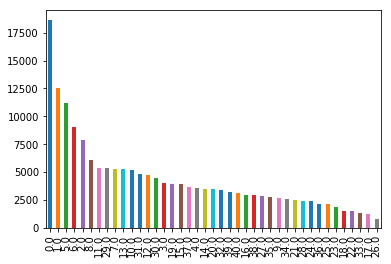

In [99]:
plot_bar(azdias, 'LP_LEBENSPHASE_FEIN')

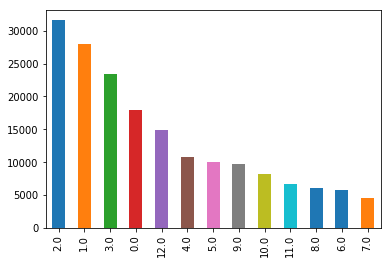

In [79]:
plot_bar(azdias, 'LP_LEBENSPHASE_GROB')

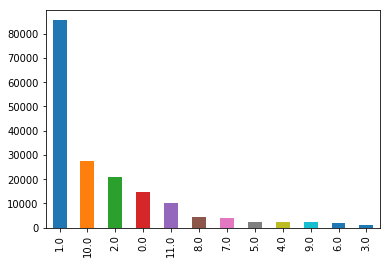

In [80]:
plot_bar(azdias, 'LP_FAMILIE_FEIN')

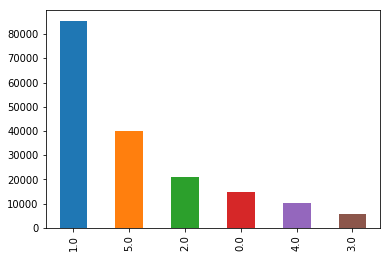

In [81]:
plot_bar(azdias, 'LP_FAMILIE_GROB')

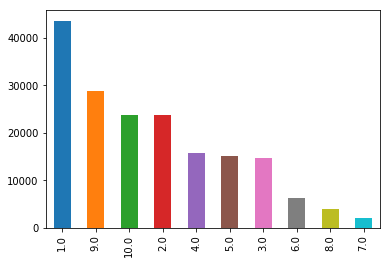

In [82]:
plot_bar(azdias, 'LP_STATUS_FEIN')

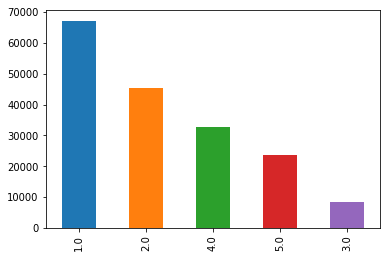

In [83]:
plot_bar(azdias, 'LP_STATUS_GROB')

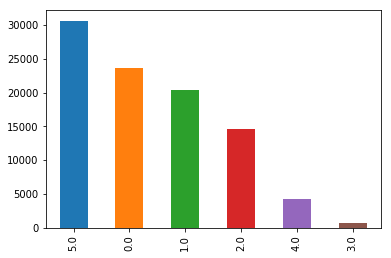

In [88]:
plot_bar(customers, 'LP_FAMILIE_GROB' )

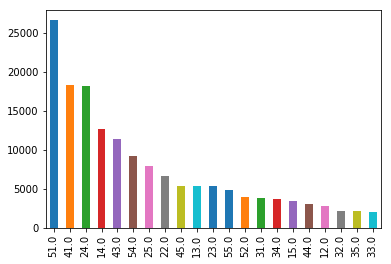

In [89]:
plot_bar(azdias, 'CAMEO_INTL_2015')

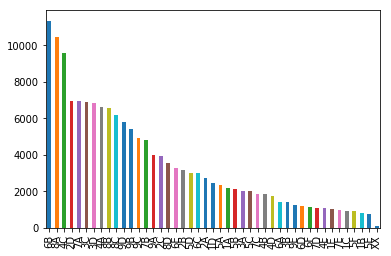

In [90]:
plot_bar(azdias, 'CAMEO_DEU_2015')

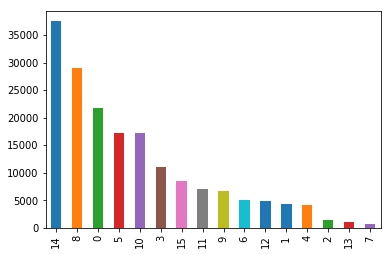

In [91]:
plot_bar(azdias, 'PRAEGENDE_JUGENDJAHRE')

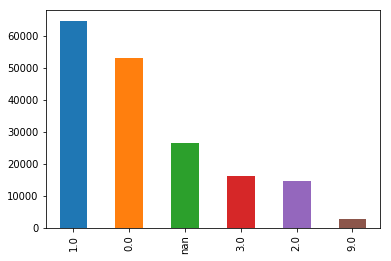

In [92]:
plot_bar(azdias, 'KBA05_ANHANG')

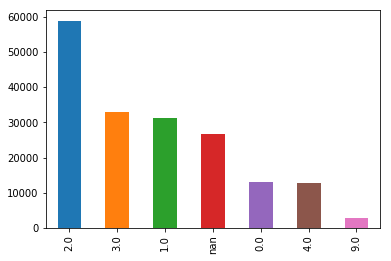

In [93]:
plot_bar(azdias, 'KBA05_DIESEL')

As can be seen, the distinction between 'FEIN' and 'GROS' is that the first is more corse than the other. Only the data with the suffix 'GROS' will be kept. There is something funny about these columns as well. Looking at the values on the horizontal axis they are out of order for it to be a linear function. It probably doesn't matter though for either the unsupervised or supervised model of predicting potential customers. Also, 'CAMEO_DEU_2015' looks like the 'fine' version of 'CAMEO_DEUG_2015' so it will be dropped too. 

In [73]:
customers = customers.drop(['LP_STATUS_FEIN','LP_FAMILIE_FEIN','LP_LEBENSPHASE_FEIN', 'CAMEO_DEU_2015'], axis = 1)
azdias = azdias.drop(['LP_STATUS_FEIN','LP_FAMILIE_FEIN','LP_LEBENSPHASE_FEIN', 'CAMEO_DEU_2015'], axis = 1)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
437149,477810,2,9.0,13.0,NaN,NaN,NaN,NaN,13.0,21.0,...,10.0,10.0,7.0,4.0,8.0,4.0,3,1,4,1992.0
676423,599286,-1,9.0,13.0,NaN,NaN,NaN,NaN,NaN,1.0,...,3.0,6.0,5.0,3.0,9.0,7.0,1,2,3,1992.0
470322,961811,-1,1.0,18.0,NaN,NaN,NaN,NaN,18.0,1.0,...,8.0,11.0,9.0,3.0,8.0,7.0,4,2,2,1992.0
113791,354340,-1,9.0,19.0,NaN,NaN,NaN,NaN,19.0,1.0,...,3.0,4.0,2.0,2.0,9.0,2.0,2,2,1,1992.0
219237,582436,-1,9.0,13.0,NaN,NaN,NaN,NaN,NaN,64.0,...,5.0,7.0,4.0,2.0,9.0,5.0,2,2,2,1992.0


One other column will be looked at. 'OST_WEST_KZ'. It is a categorical variable based on the earlier inspection of categorical variables. These categorical values 'W' and 'O' will be converted to binary.  

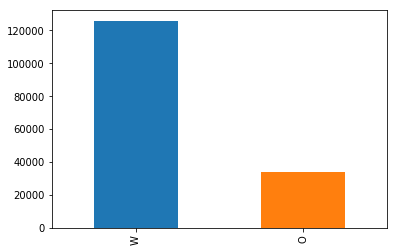

In [81]:
plot_bar(azdias, 'OST_WEST_KZ')

In [10]:
def convert_mixed(df, col_name):
    """
    Converts a dataframe's columns with mixed values and converts the values all to float
    
    INPUT:
    - df: A dataframe
    - col_name: The name of the column in the dataframe
    
    OUTPUT:
    - df_col: An organized column whose values are more consistent and of the same data type. 
    """
    df_col = df[col_name]
    values = df_col.value_counts(ascending = False)
    df_col = pd.DataFrame(df_col)
    prior_values = values.index
    prior_values = list(prior_values)
    new_values =  list(range(len(prior_values)))
    df_col = df_col.replace(prior_values, new_values)   
    return df_col

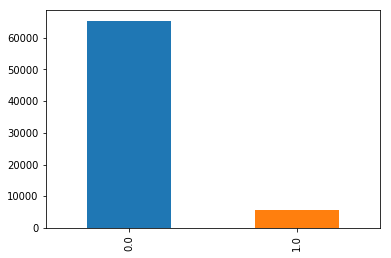

In [79]:
customers['OST_WEST_KZ'] = convert_mixed(customers, 'OST_WEST_KZ')
plot_bar(customers, 'OST_WEST_KZ')

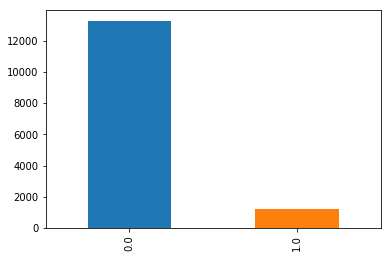

In [82]:
azdias['OST_WEST_KZ'] = convert_mixed(customers, 'OST_WEST_KZ')
plot_bar(azdias, 'OST_WEST_KZ')

Prior to re-sorting all of the columns, which could take a lot of time it would be wise to handle missing data first such as dropping columns and rows with too much missing data or replacing them with data in some way. The two functions below "fraction_missing" and also "percent_missing" provide some insight into this.  

In [11]:
def percent_missing(df):
    """
    Calulates the fraction of missing data for each column in a dataframe
    
    INPUT:
    - df: A dataframe
    
    OUTPUT:
    - df_missing: A series that includes the name of a column and the fraction of data it is missing.
    
    """
    df_missing = df.isnull().mean()
    df_missing = df_missing.sort_values(ascending = False)
    return df_missing

In [12]:
def fraction_missing(df):
    """
    A bar plot that shows the fraction of data missing on the horizontal axis and the number of columns that 
    are missing that fraction of data on the vertical axis
    
    INPUT:
    - df: A dataframe
    
    OUTPUT:
    - A bar plot showing the number of columns missing a giving fraction of data. 
    
    """
    df_missing = df.isnull().mean()
    plt.hist(df_missing, bins=40)
    plt.xlabel('Fraction of Data Missing in Azdias Dataframe')
    # naming the y axis
    plt.ylabel('Number of Columns')

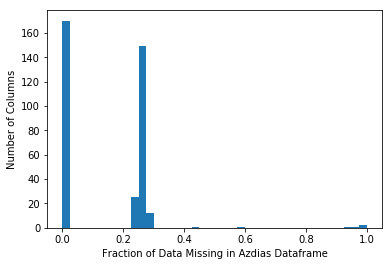

In [84]:
fraction_missing(customers)

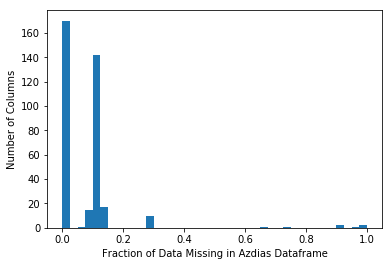

In [85]:
fraction_missing(azdias)

In [108]:
percent_missing(azdias)[1:20]

ALTER_KIND3                    0.992796
ALTER_KIND2                    0.966501
OST_WEST_KZ                    0.918785
ALTER_KIND1                    0.908737
EXTSEL992                      0.733596
KK_KUNDENTYP                   0.655366
ALTERSKATEGORIE_FEIN           0.294394
D19_GESAMT_ONLINE_QUOTE_12     0.289126
D19_KONSUMTYP                  0.289126
D19_LETZTER_KAUF_BRANCHE       0.289126
D19_LOTTO                      0.289126
D19_SOZIALES                   0.289126
D19_TELKO_ONLINE_QUOTE_12      0.289126
D19_BANKEN_ONLINE_QUOTE_12     0.289126
D19_VERSAND_ONLINE_QUOTE_12    0.289126
D19_VERSI_ONLINE_QUOTE_12      0.289126
MOBI_REGIO                     0.148156
KBA05_GBZ                      0.148156
KBA05_BAUMAX                   0.148156
dtype: float64

In [109]:
percent_missing(customers)[1:20]

ALTER_KIND3       0.993593
ALTER_KIND2       0.973462
ALTER_KIND1       0.938983
KK_KUNDENTYP      0.585186
EXTSEL992         0.444514
KBA05_ANTG1       0.290954
KBA05_ANTG2       0.290954
KBA05_BAUMAX      0.290954
KBA05_ANTG4       0.290954
KBA05_ANTG3       0.290954
KBA05_GBZ         0.290954
MOBI_REGIO        0.290954
KKK               0.281990
REGIOTYP          0.281990
VHN               0.281990
W_KEIT_KIND_HH    0.278703
HH_DELTA_FLAG     0.278703
PLZ8_HHZ          0.274299
PLZ8_GBZ          0.274299
dtype: float64

There is another column of customer information called 'GEBURTSJAHR'. It is the birthyear of the customer. It is categorical although not identified as being such in the earlier steps. A bar plot shows the distribution.

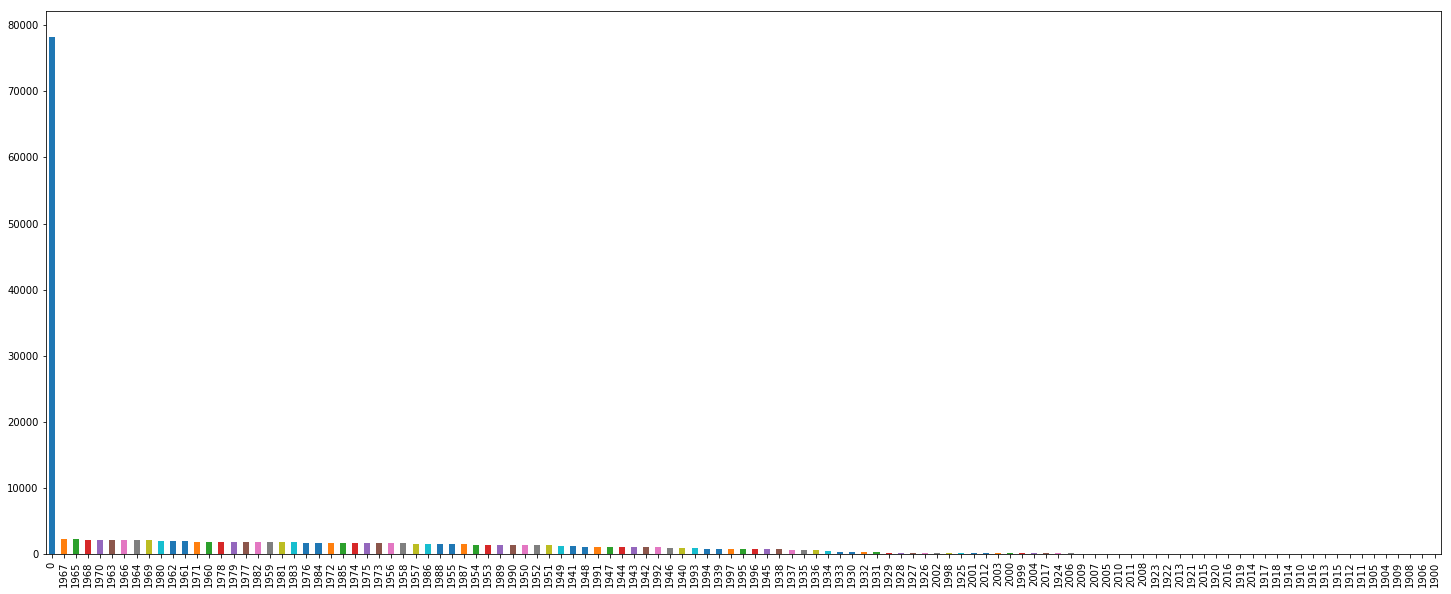

In [113]:
plt.figure(figsize=(25, 10))
plot_bar(azdias, 'GEBURTSJAHR')

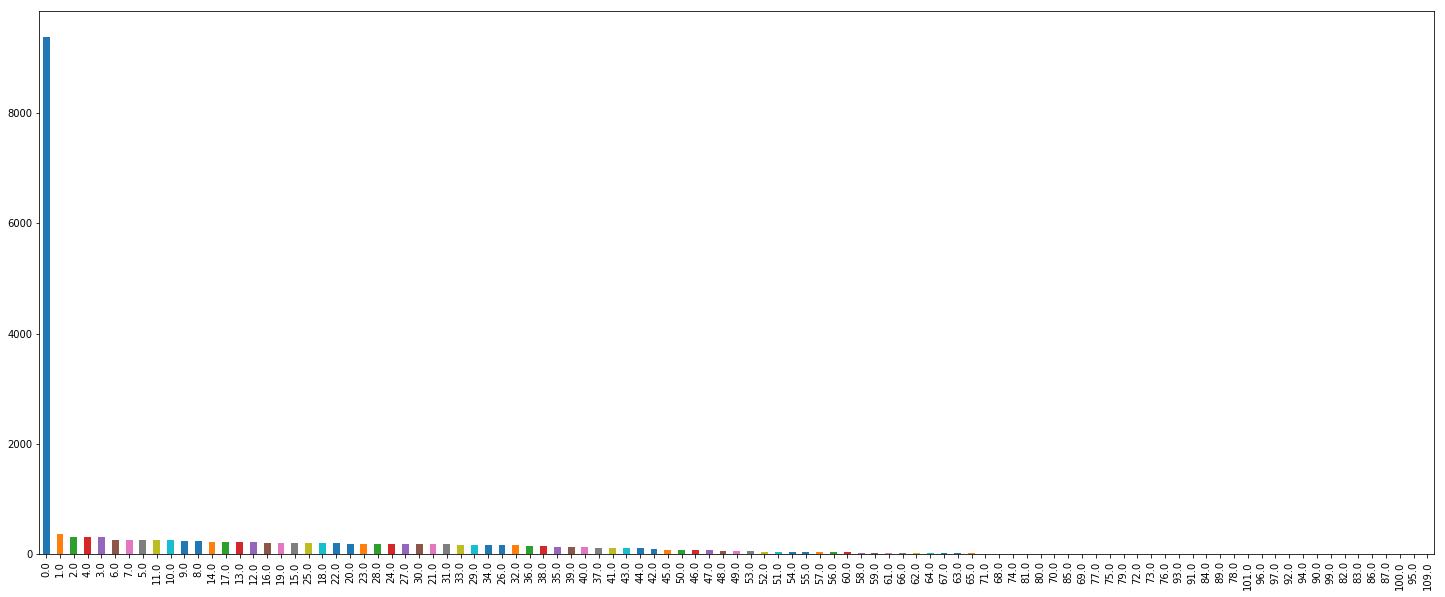

In [115]:
plt.figure(figsize=(25, 10))
azdias['GEBURTSJAHR'] = convert_mixed(customers, 'GEBURTSJAHR')
plot_bar(azdias, 'GEBURTSJAHR')

This columns looks to be dominated by the value of 0, which means 89% of the rows are missing this value. For this reason, drop it from the 'data sets'! 

In [117]:
azdias['GEBURTSJAHR'].isnull().mean()

0.89133996095240231

In [118]:
azdias = azdias.drop(['GEBURTSJAHR'], axis =1)
customers = customers.drop(['GEBURTSJAHR'], axis =1)

In [103]:
list1 = list(percent_missing(customers)[1:10].index)

In [104]:
list1

['ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'KK_KUNDENTYP',
 'EXTSEL992',
 'KBA05_ANTG1',
 'KBA05_BAUMAX',
 'KBA05_ANTG4',
 'KBA05_ANTG3']

The columns with the most missing dat will be inspected now.

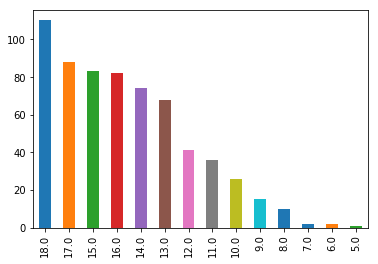

In [110]:
plot_bar(customers, 'ALTER_KIND3')

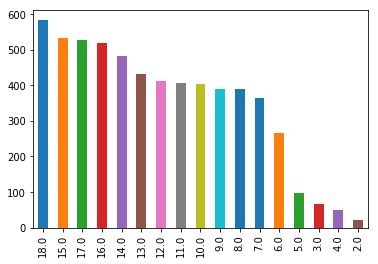

In [111]:
plot_bar(customers, 'ALTER_KIND1')

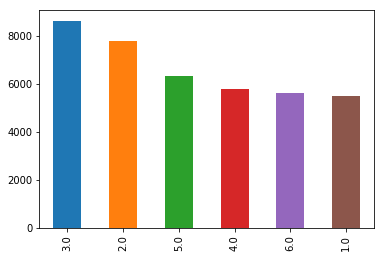

In [112]:
plot_bar(customers, 'KK_KUNDENTYP')

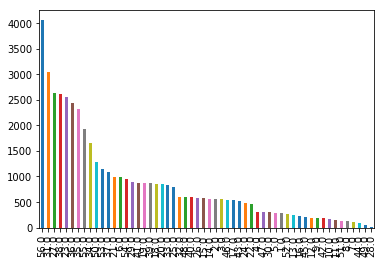

In [113]:
plot_bar(azdias, 'EXTSEL992')

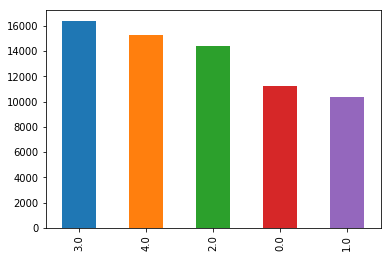

In [114]:
plot_bar(customers, 'KBA05_ANTG1')

The data for these columns 'ALTER_KIND', 'KK_KUDENTYPE', and 'EXTSEL992' look linear more or less but they have a lot of their data missing. It is probably better to just delete them from the dataframes.

In [111]:
customers = customers.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP'], axis = 1)
azdias = azdias.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP'], axis = 1)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
103003,186482,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1,NaN
182995,6040,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,NaN
97780,175399,-1,6.0,21.0,18.0,NaN,NaN,0.0,4.0,NaN,...,3.0,5.0,4.0,2.0,8.0,NaN,5,2,1,NaN
174298,163948,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1,NaN
176468,18237,1,2.0,10.0,10.0,8.0,1.0,0.0,2.0,10.0,...,4.0,2.0,1.0,6.0,9.0,7.0,3,2,4,1992.0


So, both data frames are missing a lot of data with the 'KBA05' prefix. 15% for 'azdias' and 29.4% for 'customers'. The 'azdias' frame is also missing a lot of data with the 'D19' prefix. For each data frame a subset of all the data missing for 'KBA05' will be dropped and that will reduce the dataframes by the amount they have missing, 15% and 29.4%

In [119]:
customers = customers.dropna(subset=['KBA05_GBZ'])
azdias = azdias.dropna(subset=['KBA05_GBZ']) 

In [120]:
percent_missing(customers)[0:20]

HH_DELTA_FLAG           0.048583
W_KEIT_KIND_HH          0.048583
ALTERSKATEGORIE_FEIN    0.033630
RT_UEBERGROESSE         0.023077
LP_STATUS_GROB          0.022960
RT_SCHNAEPPCHEN         0.022960
CJT_GESAMTTYP           0.022960
CJT_TYP_2               0.022960
ONLINE_AFFINITAET       0.022960
CJT_TYP_3               0.022960
LP_LEBENSPHASE_GROB     0.022960
CJT_TYP_4               0.022960
CJT_TYP_5               0.022960
LP_FAMILIE_GROB         0.022960
CJT_TYP_6               0.022960
CJT_KATALOGNUTZER       0.022960
RT_KEIN_ANREIZ          0.022960
CJT_TYP_1               0.022960
RETOURTYP_BK_S          0.022960
GFK_URLAUBERTYP         0.022960
dtype: float64

In [122]:
percent_missing(azdias)[0:20]

OST_WEST_KZ                    0.918689
ALTERSKATEGORIE_FEIN           0.232863
D19_SOZIALES                   0.230472
D19_BANKEN_ONLINE_QUOTE_12     0.230472
D19_GESAMT_ONLINE_QUOTE_12     0.230472
D19_LETZTER_KAUF_BRANCHE       0.230472
D19_LOTTO                      0.230472
D19_KONSUMTYP                  0.230472
D19_TELKO_ONLINE_QUOTE_12      0.230472
D19_VERSAND_ONLINE_QUOTE_12    0.230472
D19_VERSI_ONLINE_QUOTE_12      0.230472
HH_DELTA_FLAG                  0.042500
W_KEIT_KIND_HH                 0.042500
PLZ8_BAUMAX                    0.012230
PLZ8_ANTG2                     0.012230
PLZ8_ANTG1                     0.012230
PLZ8_ANTG3                     0.012230
PLZ8_ANTG4                     0.012230
PLZ8_HHZ                       0.012230
PLZ8_GBZ                       0.012230
dtype: float64

So at this point, there is not much missing data in the 'customers' frame and that can be dealt with easily ussing 'ffil' and 'bfil' which are 'built-ins' that just replace the missing data with that of the row ahead or behind it. But there is still alot missing in 'azdias' such as 'ALTERSKATEGORIE_FEIN', 'OST_WEST_KZ' and a few columns with prefix 'D19'. This will be dealt with by dropping the 'ALTERSKATEGORIE_FEIN', and 'OST_WEST_KZ' categories from both dataframes and dropping the rows that are missing data from 'D19_VERSAND_ONLINE_QUOTE_12'. 

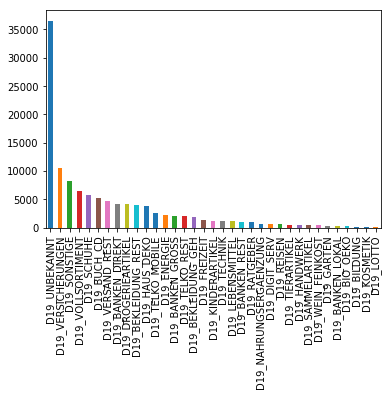

In [216]:
plot_bar(azdias, "D19_LETZTER_KAUF_BRANCHE")

In [178]:
azdias = azdias.dropna(subset=['D19_VERSAND_ONLINE_QUOTE_12']) 
customers = customers.dropna(subset=['D19_VERSAND_ONLINE_QUOTE_12']) 

In [180]:
customers = customers.drop(['ALTERSKATEGORIE_FEIN','OST_WEST_KZ'], axis = 1)
azdias = azdias.drop(['ALTERSKATEGORIE_FEIN', 'OST_WEST_KZ'], axis = 1)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
176468,18237,1,2.0,10.0,8.0,1.0,0.0,2.0,10.0,0.0,...,4.0,2.0,1.0,6.0,9.0,7.0,3,2,4,1992.0
15080,168081,-1,1.0,21.0,2.0,0.0,0.0,4.0,1.0,0.0,...,2.0,3.0,3.0,3.0,9.0,3.0,1,2,3,1992.0
154566,96011,-1,1.0,16.0,16.0,0.0,3.0,3.0,13.0,0.0,...,3.0,5.0,4.0,1.0,9.0,5.0,4,1,3,1992.0
84279,114179,-1,1.0,14.0,2.0,0.0,0.0,1.0,2.0,0.0,...,1.0,1.0,1.0,4.0,9.0,3.0,3,1,3,1992.0
34108,179202,2,1.0,10.0,6.0,0.0,0.0,2.0,6.0,0.0,...,1.0,2.0,1.0,6.0,9.0,3.0,3,2,4,1995.0


In [125]:
percent_missing(azdias)[1:20]

W_KEIT_KIND_HH          0.037170
VHN                     0.010861
KKK                     0.010861
REGIOTYP                0.010861
PLZ8_ANTG2              0.009791
PLZ8_GBZ                0.009791
PLZ8_BAUMAX             0.009791
PLZ8_ANTG4              0.009791
PLZ8_HHZ                0.009791
PLZ8_ANTG3              0.009791
PLZ8_ANTG1              0.009791
RT_UEBERGROESSE         0.006684
KBA13_HERST_AUDI_VW     0.006325
KBA13_KMH_0_140         0.006325
KBA13_HHZ               0.006325
KBA13_HERST_SONST       0.006325
KBA13_HERST_EUROPA      0.006325
KBA13_HERST_BMW_BENZ    0.006325
KBA13_HERST_ASIEN       0.006325
dtype: float64

In [126]:
percent_missing(customers)[1:20]

W_KEIT_KIND_HH         0.047251
RT_UEBERGROESSE        0.022721
RT_SCHNAEPPCHEN        0.022617
ONLINE_AFFINITAET      0.022617
RETOURTYP_BK_S         0.022617
CJT_TYP_6              0.022617
CJT_TYP_5              0.022617
CJT_TYP_4              0.022617
CJT_TYP_3              0.022617
CJT_TYP_2              0.022617
CJT_TYP_1              0.022617
CJT_KATALOGNUTZER      0.022617
CJT_GESAMTTYP          0.022617
RT_KEIN_ANREIZ         0.022617
LP_LEBENSPHASE_GROB    0.022617
LP_STATUS_GROB         0.022617
GFK_URLAUBERTYP        0.022617
LP_FAMILIE_GROB        0.022617
ANZ_HH_TITEL           0.014608
dtype: float64

So, that fixed the problem of most of the missing data. In the next step the remainder will be filled in using 'ffill' and 'bfill'

In [127]:
azdias.shape

(116842, 353)

In [128]:
customers.shape

(67427, 353)

In [14]:
columns = list(azdias.columns)
def fill_in_missing(df):
    """
    Fills in missing data with the value in the next row and if there is still missing data it fills it in with the 
    value in the previous one. 
    
    INPUT:
    - df: A dataframe
    
    OUTPUT:
    - df: A dataframe that is now cleaned of any missing data
    
    """
    for column in columns:
        df[column].fillna(method='ffill', inplace=True)
        df[column].fillna(method='bfill', inplace=True)

In [229]:
fill_in_missing(customers)

In [224]:
fill_in_missing(azdias)

In [181]:
percent_missing(customers)[0:5]

year                    0.0
KBA13_ALTERHALTER_30    0.0
KBA05_ALTER2            0.0
KBA05_ALTER3            0.0
KBA05_ALTER4            0.0
dtype: float64

In [182]:
percent_missing(azdias)[0:5]

year                    0.0
KBA13_ALTERHALTER_30    0.0
KBA05_ALTER2            0.0
KBA05_ALTER3            0.0
KBA05_ALTER4            0.0
dtype: float64

So, the missing data has been dealt with now. 

In [237]:
pickle_out = open("customers.pickle","wb")
pickle.dump(customers, pickle_out)
pickle_out.close()

In [238]:
pickle_out = open("azdias.pickle","wb")
pickle.dump(azdias, pickle_out)
pickle_out.close()

In [5]:
pickle_in = open("customers.pickle","rb")
customers = pickle.load(pickle_in)

In [4]:
pickle_in = open("azdias.pickle","rb")
azdias = pickle.load(pickle_in)

The next course of action is to split the two data frames into categorical and numerical, then scale the data, then finally to perform principle component analysis to reduce the size of the matrix by getting only the columns that contain the vast majority of useful information such that having more columns won't increase the accuracy of a supervised learning model. 

In [5]:
azdias_cat_df = azdias.select_dtypes(include=['object'])

In [10]:
customer_cat_df = customers.select_dtypes(include=['object'])

In [11]:
customer_cat_df.head()

""
176468
15080
154566
84279
34108


Note: Although at this moment there are no categorical columns before this step output 76 categorical columns when although at the beginning of the data processing there were only a few. This was encountered a few days earlier for some unknown reason, and now again. Upon inspection it appears that all the data is actually numerical however. The only column which does not appear to be numberical is 'D19_LETZTER_KAUF_BRANCHE'. It will be converted to numberical using the 'convert_mixed' function. The next steps show what was done to fix this. 

In [202]:
customer_cat_df.iloc[0:10, 70:80]

,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP
176468,3,1,1,3,2,3
15080,4,3,5,2,3,1
154566,2,4,6,2,5,4
84279,2,4,6,2,5,3
34108,3,2,3,1,3,3
129480,5,7,7,5,6,1
57081,4,6,7,5,6,1
189526,3,3,6,4,7,1
7559,2,4,6,2,5,3
97436,2,2,4,3,4,1


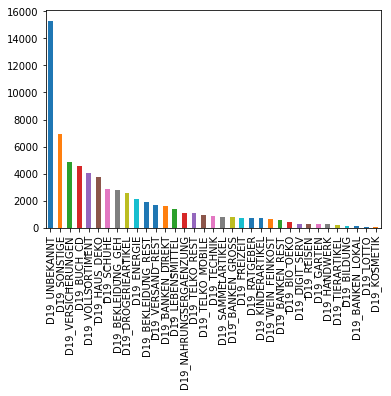

In [193]:
plot_bar(customers,'D19_LETZTER_KAUF_BRANCHE' )

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


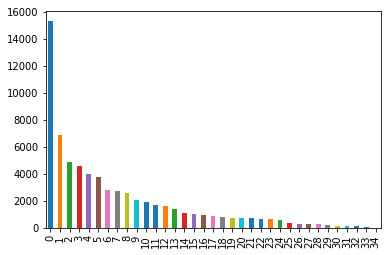

In [206]:
customer_cat_df['D19_LETZTER_KAUF_BRANCHE'] = convert_mixed(customer_cat_df,'D19_LETZTER_KAUF_BRANCHE' )
plot_bar(customer_cat_df,'D19_LETZTER_KAUF_BRANCHE')

In [207]:
for col in customer_cat_df.columns:
    customer_cat_df[col] = pd.to_numeric(customer_cat_df[col],errors = 'coerce')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [208]:
customer_cat_df.head()

,D19_LETZTER_KAUF_BRANCHE,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,...,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP
176468,0,3.0,4.0,3.0,2.0,0.0,3.0,3.0,1.0,5.0,...,1,7,1,2,3,1,1,3,2,3
15080,3,2.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,...,3,4,3,4,4,3,5,2,3,1
154566,27,3.0,4.0,2.0,1.0,1.0,2.0,4.0,3.0,2.0,...,5,6,4,5,2,4,6,2,5,4
84279,0,3.0,4.0,2.0,2.0,1.0,3.0,3.0,2.0,4.0,...,5,4,2,4,2,4,6,2,5,3
34108,4,3.0,2.0,3.0,4.0,1.0,4.0,4.0,3.0,2.0,...,1,7,3,4,3,2,3,1,3,3


In [211]:
customer_cat_df.select_dtypes(include=['object']).shape

(67427, 0)

Okay, so that annoying step seems to be working now. It will done for the original 'customers' and 'azdias' data frames as well so that all the data is numerical.

In [212]:
customers['D19_LETZTER_KAUF_BRANCHE'] = convert_mixed(customers,'D19_LETZTER_KAUF_BRANCHE')
azdias['D19_LETZTER_KAUF_BRANCHE'] = convert_mixed(azdias,'D19_LETZTER_KAUF_BRANCHE' )

In [213]:
for col in customer_cat_df.columns:
    customers[col] = pd.to_numeric(customers[col],errors = 'coerce')

In [214]:
for col in customer_cat_df.columns:
    azdias[col] = pd.to_numeric(azdias[col],errors = 'coerce')

In [215]:
numerical_df = azdias.select_dtypes(exclude=['object'])

In [216]:
numerical_df.shape

(116842, 353)

In [217]:
azdias.shape

(116842, 353)

In [6]:
customers.shape

(67427, 353)

In [9]:
percent_missing(customers)[0:5]

year                    0.0
KBA13_ALTERHALTER_30    0.0
KBA05_ALTER2            0.0
KBA05_ALTER3            0.0
KBA05_ALTER4            0.0
dtype: float64

In [226]:
percent_missing(azdias)[0:5]

year                    0.0
KBA13_ALTERHALTER_30    0.0
KBA05_ALTER2            0.0
KBA05_ALTER3            0.0
KBA05_ALTER4            0.0
dtype: float64

So, at last the data pre-processing looks to be complete. All of the data is numerical as well. 

## EVALUATION I. UNSUPERVISED MODEL (Clustering)

Now that the data in the dataframes has been pre-processed it can evaluated in order to achieve the desired result of segmenting the customers into clusters and then determining which of the cluster(s) contain data the yield likely customers for the company. After the clustering is complete a classification model will be chosen based on how well predicts if an indidual will become a customer for the company  by testing the performance on the 'training data set'. Lastly the classification model will be used on a 'test set' of data and the results will be submitted to a Kaggle competition. 

Firstly the dataframes are 'normalized' to get two dataframes 'azdias_normalized', and 'customers_normalized'. Next, the columns with the highest variance are selected using PCA (Principal Component Analysis) and the dataframes are reduced in size based on the desired total variance. 88.9% was the target for total variance, this means 88.9% of the mathematical information is retained. After that the reduced in size dataframes will be used for cluster analysis. 

In [9]:
x = azdias.values
x = StandardScaler().fit_transform(x) # normalizing the features

In [13]:
x2 = customers.values
x2 = StandardScaler().fit_transform(x2) # normalizing the features

In [14]:
all_columns = customers.columns

In [12]:
azdias_normalized = pd.DataFrame(x, columns= all_columns)

In [15]:
customers_normalized = pd.DataFrame(x2, columns= all_columns)

In [13]:
azdias_normalized.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
0,-0.138169,-0.634278,1.612190,0.124516,-0.454398,-0.127258,-0.330142,0.913062,-0.442106,-0.063102,...,-0.840250,-0.227521,-0.122798,-0.503264,0.582918,1.513658,-1.598442,0.960173,0.149187,-0.434109
1,1.271886,-0.634278,-0.772678,0.830378,-0.454398,-0.127258,-0.330142,0.091417,-0.442106,-0.063102,...,1.006241,1.381428,1.339600,-0.503264,0.080963,1.513658,0.508003,0.960173,-0.777666,-0.434109
2,-1.090896,-0.634278,1.612190,0.971550,-0.454398,-0.127258,-0.330142,0.913062,-0.442106,-0.063102,...,-0.840250,-0.871101,-1.219597,-1.029506,0.582918,-1.067658,-0.896294,0.960173,-1.704520,-0.434109
3,-0.203708,-0.634278,1.612190,0.124516,3.855139,-0.127258,-0.330142,0.913062,3.983685,-0.063102,...,-0.101653,0.094269,-0.488397,-1.029506,0.582918,0.481132,-0.896294,0.960173,-0.777666,-0.434109
4,1.524150,-0.634278,1.612190,-1.710726,-0.317588,-0.127258,-0.330142,0.091417,-0.294579,-0.063102,...,0.636943,1.059638,0.974001,0.022979,0.080963,-0.551394,1.210152,0.960173,-0.777666,-0.434109


In [16]:
customers_normalized.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
0,-1.398813,0.150243,0.152401,-0.217100,0.206088,1.599743,-0.265503,-0.205659,0.366030,-0.135308,...,-0.121070,-0.872354,-0.953821,0.911879,0.279003,1.591615,0.459448,1.422830,0.653078,-0.389360
1,1.305752,-1.367429,-0.368797,1.546580,-0.204912,-0.123326,-0.265503,1.234016,-0.257786,-0.135308,...,-0.805284,-0.524079,-0.047144,-0.667366,0.279003,-0.348393,-1.076572,1.422830,-0.674480,-0.389360
2,0.004946,-1.367429,-0.368797,0.744907,0.754089,-0.123326,6.139522,0.514179,0.573969,-0.135308,...,-0.463177,0.172472,0.406194,-1.720195,0.279003,0.621611,1.227459,-0.702825,-0.674480,-0.389360
3,0.332864,-1.367429,-0.368797,0.424238,-0.204912,-0.123326,-0.265503,-0.925496,-0.188473,-0.135308,...,-1.147391,-1.220630,-0.953821,-0.140951,0.279003,-0.348393,0.459448,-0.702825,-0.674480,-0.389360
4,1.506477,0.909080,-0.368797,-0.217100,0.069088,-0.123326,-0.265503,-0.205659,0.088779,-0.135308,...,-1.147391,-0.872354,-0.953821,0.911879,0.279003,-0.348393,0.459448,1.422830,0.653078,0.879818


In [267]:
pickle_out = open("azdias_normalized.pickle","wb")
pickle.dump(azdias_normalized, pickle_out)
pickle_out.close()

In [17]:
pickle_out = open("customers_normalized.pickle","wb")
pickle.dump(customers_normalized, pickle_out)
pickle_out.close()

In [2]:
pickle_in = open("azdias_normalized.pickle","rb")
customers_normalized = pickle.load(pickle_in)

In [3]:
pickle_in = open("customers_normalized.pickle","rb")
customers_normalized = pickle.load(pickle_in)

In [ ]:
In this step the dataframe will be 

In [90]:
from sklearn.decomposition import PCA
pca_azdias = PCA(n_components = 160)
principalComponents_azdias = pca_azdias.fit_transform(azdias_normalized)

In [136]:
principalComponents_customers = pca_azdias.fit_transform(customers_normalized)

In [33]:
#principalComponents_azdias

In [91]:
feat_cols = ['P.C. '+str(i) for i in range(160)]

In [92]:
principal_azdias_Df = pd.DataFrame(data = principalComponents_azdias, columns = feat_cols)

In [137]:
principal_customers_Df = pd.DataFrame(data = principalComponents_customers, columns = feat_cols)

In [278]:
pickle_out = open("principal_azdias_Df.pickle","wb")
pickle.dump(principal_azdias_Df, pickle_out)
pickle_out.close()

In [279]:
pickle_out = open("principal_customers_Df.pickle","wb")
pickle.dump(principal_customers_Df, pickle_out)
pickle_out.close()

In [4]:
pickle_in = open("principal_customers_Df.pickle","rb")
principal_customers_Df = pickle.load(pickle_in)

In [93]:
principal_azdias_Df.head()

,P.C. 0,P.C. 1,P.C. 2,P.C. 3,P.C. 4,P.C. 5,P.C. 6,P.C. 7,P.C. 8,P.C. 9,...,P.C. 150,P.C. 151,P.C. 152,P.C. 153,P.C. 154,P.C. 155,P.C. 156,P.C. 157,P.C. 158,P.C. 159
0,-7.156659,-2.407992,0.086537,0.655078,1.122570,-2.892410,-1.315297,-0.414013,-2.085592,1.051141,...,0.524360,-1.683356,-0.299215,-0.648709,-0.118782,-0.216640,1.125278,0.809527,-0.787899,1.878583
1,-5.389796,-2.699948,3.861047,0.246881,-5.052891,-0.456499,-2.829218,0.597720,0.562909,3.961479,...,0.641833,-0.253757,0.043849,0.464900,0.525287,-0.089047,-0.387615,-0.631802,0.781766,0.884611
2,-6.245273,-3.105142,4.663261,0.580896,0.414425,0.848765,-3.323330,-2.975408,-1.945384,0.431722,...,1.084474,-0.058234,-1.028193,0.511805,0.456302,0.770181,-0.831798,1.832472,1.391437,-0.604664
3,9.738569,-1.226810,2.160846,-2.511494,-0.780968,4.093778,-1.804350,4.580834,6.206860,-2.908853,...,-0.604646,-0.047841,0.211838,0.102841,-0.340681,-0.713230,-1.564026,-0.993565,0.955350,0.613095
4,7.979906,-2.017076,2.443577,-1.080655,-4.630266,-1.499326,-2.611856,-0.447145,3.741798,-0.227067,...,0.907202,0.125205,1.084251,1.469251,-0.146320,-0.845255,-0.374021,-0.446310,0.768352,-0.028590


In [94]:
principal_azdias_Df.shape

(116842, 160)

In [138]:
principal_customers_Df.head()

,P.C. 0,P.C. 1,P.C. 2,P.C. 3,P.C. 4,P.C. 5,P.C. 6,P.C. 7,P.C. 8,P.C. 9,...,P.C. 150,P.C. 151,P.C. 152,P.C. 153,P.C. 154,P.C. 155,P.C. 156,P.C. 157,P.C. 158,P.C. 159
0,1.047147,-1.850227,5.262159,0.310018,3.626452,3.167466,-5.511553,1.659346,-3.860427,0.328238,...,-0.263934,-0.228427,-0.166497,0.102451,-0.183809,-0.119958,0.229428,-0.620367,0.024616,0.769632
1,-2.611862,3.062793,-4.267347,0.104265,1.015702,1.432957,0.989647,-4.979820,-0.047656,-2.490387,...,1.327517,-0.427220,-0.492411,-0.973279,0.634289,-0.466367,-1.267178,0.533851,-0.286563,-0.226191
2,6.324143,-6.082975,-7.126766,2.612017,0.499538,2.679932,4.553711,4.408593,0.415256,-2.484744,...,0.368837,0.201199,-0.644498,-1.971307,2.119503,0.039033,-0.074999,-1.396012,-0.332650,0.300418
3,3.880698,1.655260,-2.063091,-1.026856,3.137785,-2.475529,2.429579,0.499885,-0.735965,-1.480861,...,-0.754512,0.453085,0.473715,0.453077,-0.461094,0.355786,-1.406677,0.212764,-1.068966,0.086141
4,4.645964,-7.378435,0.683959,-0.175758,-4.403234,7.662837,2.380499,0.008718,-3.845382,1.534478,...,0.098064,-0.130318,1.835960,-0.639352,-1.684089,1.033896,0.346448,0.458967,0.555468,-0.099498


Next order of business is to make a data frame that shows the variance of the PCA. 

In [95]:
explained_variance = pca_azdias.explained_variance_ratio_

In [96]:
cumulative_variance = np.cumsum(np.round(explained_variance, decimals = 3))

In [97]:
pca_df = pd.DataFrame(feat_cols, columns = ['PC'])

In [98]:
explained_variance_df = pd.DataFrame(explained_variance, columns = ['Explained Variance'])

In [99]:
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns = ['Cumulative Variance'])

In [100]:
df_explained_variance = pd.concat([pca_df, explained_variance_df, cumulative_variance_df], axis = 1)

In [101]:
df_explained_variance.head(15)

,PC,Explained Variance,Cumulative Variance
0,P.C. 0,0.075971,0.076
1,P.C. 1,0.060274,0.136
2,P.C. 2,0.051322,0.187
3,P.C. 3,0.046922,0.234
4,P.C. 4,0.035446,0.269
5,P.C. 5,0.022866,0.292
6,P.C. 6,0.020113,0.312
7,P.C. 7,0.017299,0.329
8,P.C. 8,0.015681,0.345
9,P.C. 9,0.014008,0.359


In [102]:
df_explained_variance.tail(10)

,PC,Explained Variance,Cumulative Variance
150,P.C. 150,0.001657,0.871
151,P.C. 151,0.001635,0.873
152,P.C. 152,0.001624,0.875
153,P.C. 153,0.001612,0.877
154,P.C. 154,0.001595,0.879
155,P.C. 155,0.001579,0.881
156,P.C. 156,0.001572,0.883
157,P.C. 157,0.001565,0.885
158,P.C. 158,0.001553,0.887
159,P.C. 159,0.001528,0.889


Next, create visualization of how the variance increases along with the number of PC's! 

In [103]:
pc_num = []
for i in range(160):
    pc_num.append(i)

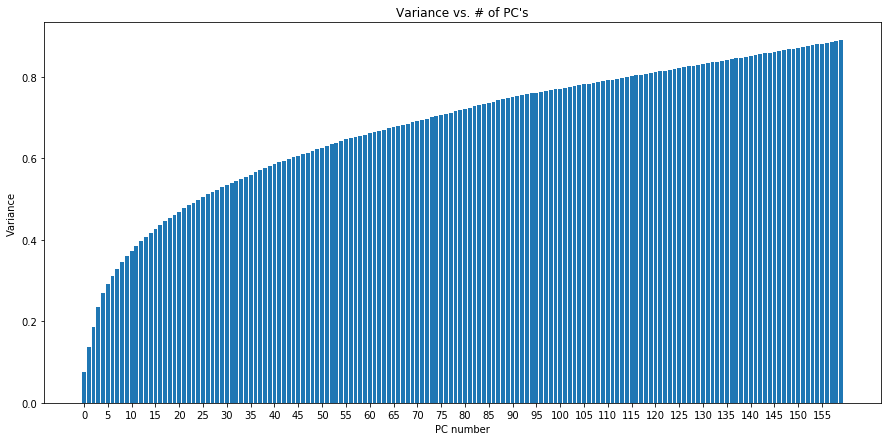

In [104]:
plt.figure(figsize=(15,7))
plt.bar(pc_num, cumulative_variance)
plt.xticks(np.arange(0, 160, 5))
plt.xlabel('PC number')
# naming the y axis
plt.ylabel('Variance')
plt.title("Variance vs. # of PC's")
plt.show()

So, having 160 PC's retains 88.9% of the variance. It takes a good chunk of time to compute that so increasing the amount of PC's would only increase the amount of computation time. There is a time vs. accuracy balance that has to be acheived while working with massive datasets like this. Hopefully 88.9% is enough to have an accurate enough Supervised Learning model. 

It would be desirable to know what are the most and least dominating numerical columns of the original data frame for each principle component. This can be ascertained using .components_ method:

In [105]:
pca_relevance = pca_azdias.components_
pca_relevance.shape

(160, 353)

In [106]:
type(pca_relevance)

numpy.ndarray

So, now the pca_relevance numpy array provides the information as to what the weight is of each numerical column for the respective principal component. Convert the numpy array to a data frame so its easier to work with!

In [107]:
all_columns = list(all_columns)

In [108]:
len(all_columns)

353

In [109]:
pc_relevance = pd.DataFrame(pca_relevance, columns = all_columns)

In [110]:
pc_relevance.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
0,-0.024511,-0.019095,0.052084,-0.029339,0.082943,0.020996,-0.024939,-0.075290,0.080080,-0.001808,...,0.082291,0.085141,0.077103,0.047752,-0.040077,-0.054334,0.087301,0.004186,-0.029255,-0.030261
1,0.007599,0.026797,0.010379,-0.036673,0.026902,0.014769,-0.023963,-0.031646,0.031080,0.003338,...,0.051438,0.035857,0.016948,0.038870,0.005038,-0.014734,-0.003785,-0.000138,0.036995,-0.003313
2,0.003563,-0.110308,0.024628,0.090668,0.016285,-0.001047,0.066665,0.056642,0.014501,-0.002914,...,-0.107864,-0.056133,0.002170,-0.097598,-0.067132,-0.008822,0.036608,0.009762,-0.139947,0.008678
3,-0.085754,0.000057,-0.003909,0.003905,-0.007238,-0.022746,0.001848,0.008300,-0.005203,-0.011946,...,-0.009247,-0.010240,-0.013266,-0.008162,0.006401,0.085046,0.017779,-0.001883,0.004172,0.033976
4,-0.041476,0.110738,-0.105753,0.005986,0.031919,0.019047,-0.004608,0.068379,0.032627,0.010735,...,-0.108838,-0.141426,-0.144924,0.009335,0.049923,-0.059129,-0.054318,0.003408,0.114737,-0.015308


So, this looks really good because now the data frame 'pc_relevance' informs what the columns weights are for each principle component. The principle component is the row in this data frame. 

In [280]:
pickle_out = open("pc_relevance","wb")
pickle.dump(pc_relevance, pickle_out)
pickle_out.close()

In [3]:
pickle_in = open("pc_relevance","rb")
pc_relevance = pickle.load(pickle_in)

In [111]:
pc_relevance.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
0,-0.024511,-0.019095,0.052084,-0.029339,0.082943,0.020996,-0.024939,-0.075290,0.080080,-0.001808,...,0.082291,0.085141,0.077103,0.047752,-0.040077,-0.054334,0.087301,0.004186,-0.029255,-0.030261
1,0.007599,0.026797,0.010379,-0.036673,0.026902,0.014769,-0.023963,-0.031646,0.031080,0.003338,...,0.051438,0.035857,0.016948,0.038870,0.005038,-0.014734,-0.003785,-0.000138,0.036995,-0.003313
2,0.003563,-0.110308,0.024628,0.090668,0.016285,-0.001047,0.066665,0.056642,0.014501,-0.002914,...,-0.107864,-0.056133,0.002170,-0.097598,-0.067132,-0.008822,0.036608,0.009762,-0.139947,0.008678
3,-0.085754,0.000057,-0.003909,0.003905,-0.007238,-0.022746,0.001848,0.008300,-0.005203,-0.011946,...,-0.009247,-0.010240,-0.013266,-0.008162,0.006401,0.085046,0.017779,-0.001883,0.004172,0.033976
4,-0.041476,0.110738,-0.105753,0.005986,0.031919,0.019047,-0.004608,0.068379,0.032627,0.010735,...,-0.108838,-0.141426,-0.144924,0.009335,0.049923,-0.059129,-0.054318,0.003408,0.114737,-0.015308


In [112]:
comp_0 = pc_relevance.iloc[0]

In [113]:
comp_0[1:20]

AGER_TYP                     -0.019095
AKT_DAT_KL                    0.052084
ALTER_HH                     -0.029339
ANZ_HAUSHALTE_AKTIV           0.082943
ANZ_HH_TITEL                  0.020996
ANZ_KINDER                   -0.024939
ANZ_PERSONEN                 -0.075290
ANZ_STATISTISCHE_HAUSHALTE    0.080080
ANZ_TITEL                    -0.001808
ARBEIT                        0.094367
BALLRAUM                     -0.074129
CAMEO_DEUG_2015               0.132199
CAMEO_INTL_2015               0.129296
CJT_GESAMTTYP                 0.001668
CJT_KATALOGNUTZER             0.034546
CJT_TYP_1                     0.037369
CJT_TYP_2                     0.060119
CJT_TYP_3                    -0.055433
CJT_TYP_4                    -0.025294
Name: 0, dtype: float64

In the next step a function will be created that gives the most and least relevant columns of a given principle component through a bar graph and explains what each means:

In [15]:
def relevant_columns(pc):
    """
    Takes the n'th principle component as an input and outputs information about the customers 
    including the top five most pertinent and least pertinent columns and their descriptions if one is available
    
    INPUT:
    - pc: The principal component from the PCA step
    
    OUTPUT:
    - component_info: Provides the feature, description of the feature, and variance for that feature for the pc input
    
    """
    descriptions = []
    descriptions_parsed = []

    
    pc_info = list(zip(pc_relevance.iloc[pc], all_columns))
    pc_info.sort()
    most_important = pc_info[-5:]
    most_important.sort(reverse = True)
    least_important = pc_info[0:5]
    least_important.sort(reverse = True)
    full_list = most_important + least_important
    unzipped_full = list(zip(*full_list))
    full_vals = unzipped_full[0]
    full_col_names = unzipped_full[1]
    plt.figure(figsize=(25,7))
    #plt.bar(most_important_col_names, most_important_vals)
    s = pd.Series(full_vals, index = full_col_names)
    s.plot(kind='bar',rot=0, title = "PC Variance of a Column vs. Column Name")
    plt.xlabel('Column Name')
    plt.ylabel('Variance')
    
    for name in full_col_names:
        description = feature_values[feature_values['Attribute'] == name]['Description'][0:1]
        descriptions.append(str(description))
    for desc in descriptions:
        descriptions2 = desc.split("\nName")[0][4:]
        descriptions_parsed.append(descriptions2)
    component_info = {"Feature":full_col_names, "Description":descriptions_parsed, "Variance": full_vals}
    component_info = pd.DataFrame(component_info)
    component_info
    
    component_info['Description'].replace('es([], Name: Description, dtype: object)', 'Unknown description', inplace=True)

    return component_info

,Feature,Description,Variance
0,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,0.146041
1,KBA13_ANTG3,Unknown description,0.145673
2,KBA13_ANTG4,Unknown description,0.142095
3,KBA13_BAUMAX,Unknown description,0.141759
4,PLZ8_ANTG4,number of >10 family houses in the PLZ8,0.140194
5,MOBI_RASTER,Unknown description,-0.135379
6,KBA05_ANTG1,number of 1-2 family houses in the cell,-0.136438
7,KBA13_ANTG1,Unknown description,-0.145414
8,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,-0.145616
9,MOBI_REGIO,moving patterns,-0.148031


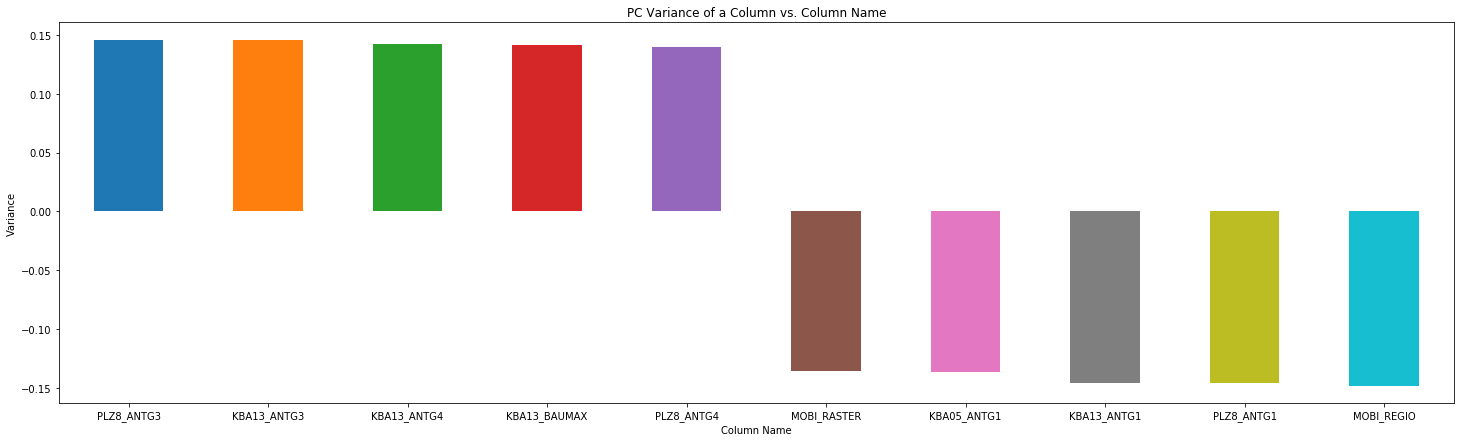

In [115]:
relevant_columns(0)

,Feature,Description,Variance
0,KBA05_SEG6,share of upper class cars (BMW 7er etc.) i...,0.194376
1,KBA05_KRSOBER,share of upper class cars (referred to the ...,0.169211
2,KBA05_KRSVAN,share of vans (referred to the county average),0.165244
3,KBA05_KRSZUL,share of newbuilt cars (referred to the cou...,0.161820
4,KBA05_SEG8,share of roadster and convertables in the ...,0.156635
5,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last...,-0.050236
6,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth ...,-0.051005
7,FINANZ_ANLEGER,financial typology: investor,-0.052404
8,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last...,-0.054212
9,ONLINE_AFFINITAET,online affinity,-0.059658


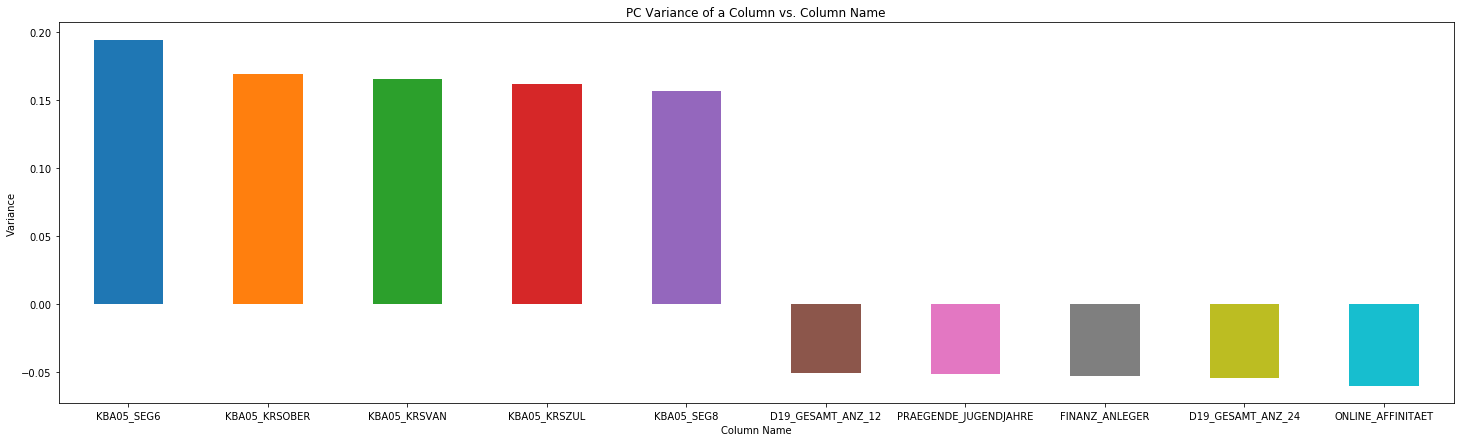

In [116]:
relevant_columns(1)

,Feature,Description,Variance
0,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth ...,0.167146
1,CJT_TYP_2,Unknown description,0.164987
2,CJT_TYP_1,Unknown description,0.162366
3,ONLINE_AFFINITAET,online affinity,0.161006
4,FINANZ_SPARER,financial typology: money saver,0.159635
5,CJT_TYP_6,Unknown description,-0.147708
6,FINANZ_VORSORGER,financial typology: be prepared,-0.148518
7,CJT_TYP_4,Unknown description,-0.148671
8,CJT_TYP_3,Unknown description,-0.149673
9,CJT_TYP_5,Unknown description,-0.151885


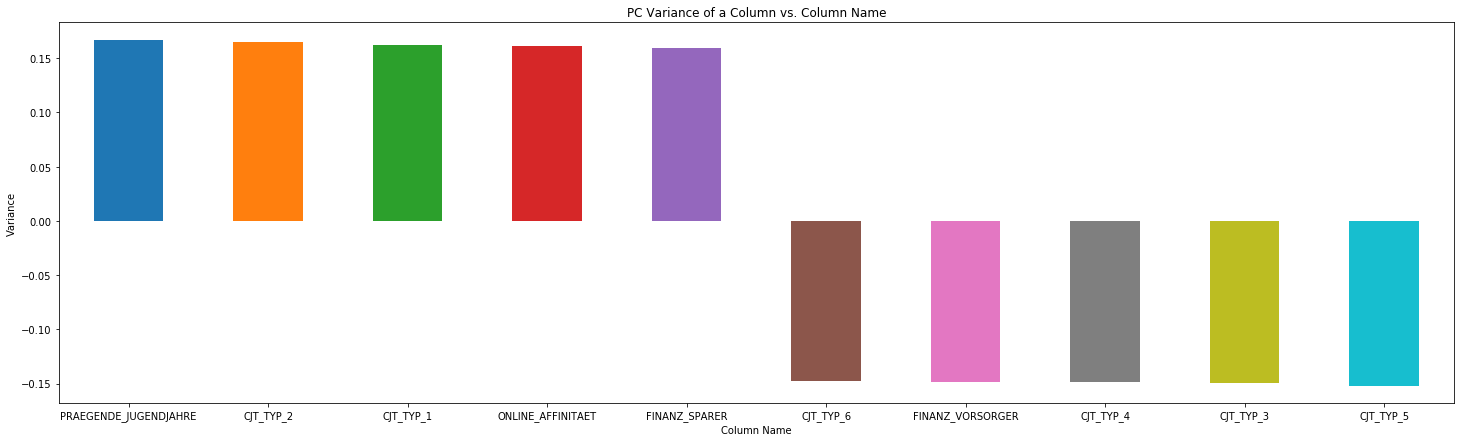

In [117]:
relevant_columns(2)

,Feature,Description,Variance
0,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,0.157728
1,KBA13_SEG_KLEINWAGEN,share of small and very small cars (Ford F...,0.139844
2,KBA13_KMH_140_210,share of cars with max speed between 140 a...,0.138743
3,KBA13_HALTER_25,share of car owners between 21 and 25 with...,0.130203
4,KBA13_KMH_180,share of cars with max speed between 110 k...,0.128495
5,KBA13_SITZE_4,number of cars with less than 5 seats in t...,-0.152220
6,KBA13_BMW,share of BMW within the PLZ8,-0.159028
7,KBA13_SEG_OBEREMITTELKLASSE,share of upper middle class cars and upper...,-0.163898
8,KBA13_MERCEDES,share of MERCEDES within the PLZ8,-0.166242
9,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,-0.191973


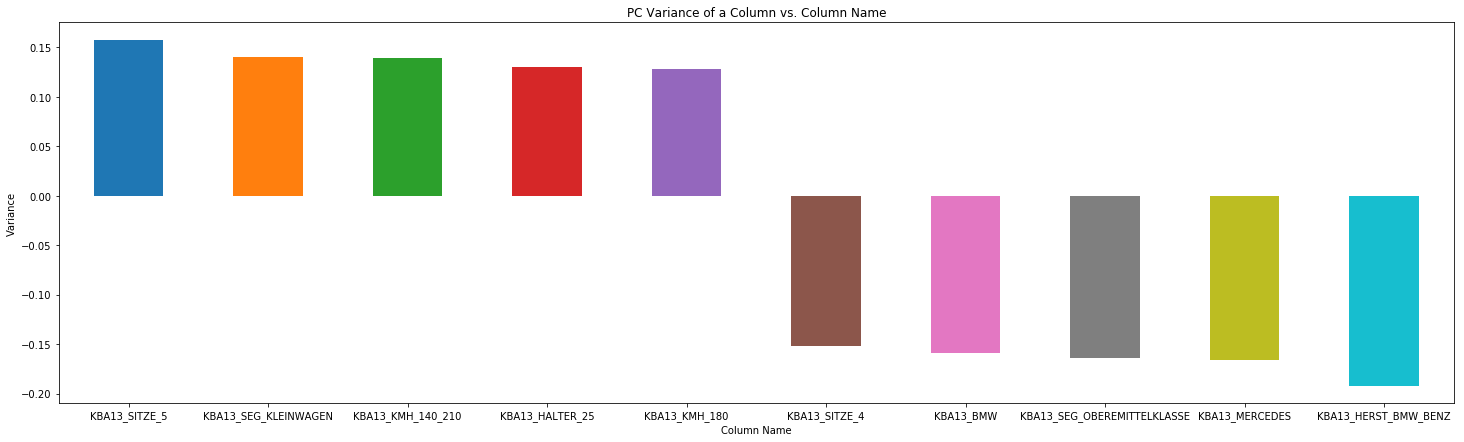

In [118]:
relevant_columns(3)

In [203]:
def Kmeans_scores(data, K_start, K_end, step=1):
    
    """
    Provides insight into cluster scores for a dataset
    
    INPUT:
    - data: The dataframe that will be organized into a set of clusters
    - K_start: The minimum amount of clusters
    - K_end: The final amount of clusters
    - step: The step count
    
    OUTPUT:
    - score: The calculated cluster score
    
    """
    
    scores = []
    
    print("K-means clustering initiated")
    print("for range min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for n in range(K_start, K_end+1, step):
        
        print("\nTraining for cluster", n)
        
        kmeans = KMeans(n)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        print("The score for this cluster is: ", scores[-1])        
    return scores, range(K_start, K_end+1, step)

In [204]:
Kmeans_scores(principal_azdias_Df,2, 20, 1)

K-means clustering initiated
for range min:2, max:20, step:1

Training for cluster 2
The score for this cluster is:  33982881.2043

Training for cluster 3
The score for this cluster is:  31724816.8529

Training for cluster 4
The score for this cluster is:  30664996.6205

Training for cluster 5
The score for this cluster is:  30037971.5836

Training for cluster 6
The score for this cluster is:  29465664.733

Training for cluster 7
The score for this cluster is:  29015393.5004

Training for cluster 8
The score for this cluster is:  28666787.4871

Training for cluster 9
The score for this cluster is:  28377739.0773

Training for cluster 10
The score for this cluster is:  28116590.5233

Training for cluster 11
The score for this cluster is:  27920257.7565

Training for cluster 12
The score for this cluster is:  27745793.9459

Training for cluster 13
The score for this cluster is:  27580023.7031

Training for cluster 14
The score for this cluster is:  27302610.4997

Training for cluster 16


([33982881.204325929,
  31724816.852946427,
  30664996.620472208,
  30037971.583631352,
  29465664.732956439,
  29015393.500421897,
  28666787.487120897,
  28377739.077254619,
  28116590.523317799,
  27920257.756548479,
  27745793.945893832,
  27580023.703058168,
  27416571.414220888,
  27302610.499724377,
  27193200.110137958,
  27085482.66649168,
  26917800.020053986,
  26840015.878407951,
  26728292.134926222],
 range(2, 21))

In [206]:
scores = [33982881.204325929,
  31724816.852946427,
  30664996.620472208,
  30037971.583631352,
  29465664.732956439,
  29015393.500421897,
  28666787.487120897,
  28377739.077254619,
  28116590.523317799,
  27920257.756548479,
  27745793.945893832,
  27580023.703058168,
  27416571.414220888,
  27302610.499724377,
  27193200.110137958,
  27085482.66649168,
  26917800.020053986,
  26840015.878407951,
  26728292.134926222]

In [207]:
from matplotlib import pyplot as plt

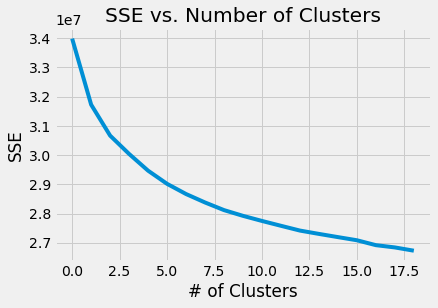

In [208]:
plt.plot(scores)
plt.xlabel("# of Clusters")
plt.ylabel("SSE")
plt.title("SSE vs. Number of Clusters")
plt.show()

The graph above is useful to determine how many clusters should be selected. The 'elbow method' is the industry standard whereupon the number is chosed based on when the curve starts to flatten out. This isn't very clear in the graph above but it appears to do so when the horizontal axis value is around 8-10. The analysis will look at 8 and 9 clusters.

In [139]:
kmeans = KMeans(8, random_state=21)

kmeans.fit(principal_azdias_Df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=21, tol=0.0001, verbose=0)

In [140]:
azdias_clusters = kmeans.predict(principal_azdias_Df)

In [141]:
azdias_clusters = pd.Series(azdias_clusters)

In [142]:
azdias_clusters.value_counts().sort_index()

0    21156
1    17882
2    21375
3     9516
4    17158
5     1440
6    11462
7    16853
dtype: int64

In [157]:
azdias_groups = list(azdias_clusters.value_counts().sort_index().values)

In [158]:
azdias_groups

[21156, 17882, 21375, 9516, 17158, 1440, 11462, 16853]

In [228]:
azdias_groups_percentages = list((azdias_groups/sum(azdias_groups))*100)
azdias_groups_percentages

[18.106502798651171,
 15.304428202187569,
 18.293935399941802,
 8.1443316615600558,
 14.684788004313518,
 1.2324335427329214,
 9.809828657503294,
 14.423751733109668]

In [143]:
customers_clusters = kmeans.predict(principal_customers_Df)

In [144]:
customers_clusters = pd.Series(customers_clusters)

In [145]:
customers_clusters.value_counts().sort_index()

0    15518
1    12463
2    14460
3     1474
4    10083
5        9
6     3996
7     9424
dtype: int64

In [229]:
customer_groups = list(customers_clusters.value_counts().sort_index().values)
customer_groups

[15518, 12463, 14460, 1474, 10083, 9, 3996, 9424]

In [230]:
customer_groups_percentages = (customer_groups/sum(customer_groups))*100
customer_groups_percentages

array([  2.30145194e+01,   1.84836935e+01,   2.14454150e+01,
         2.18606790e+00,   1.49539502e+01,   1.33477687e-02,
         5.92640930e+00,   1.39765969e+01])

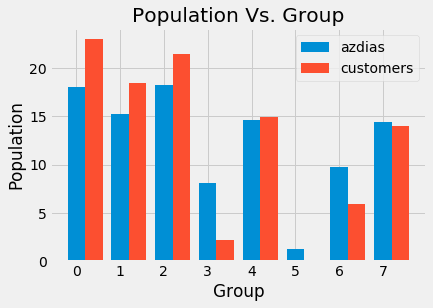

In [233]:

w = 0.4
x = list(range(8))
x2 = [i + w for i in x] 
plt.bar(x, azdias_groups_percentages, w, label = "azdias")
plt.bar(x2, customer_groups_percentages, w, label = "customers")
plt.xlabel("Group")
plt.ylabel("Population")
plt.title("Population Vs. Group")
plt.xticks(x)
plt.legend()
plt.show()


Repeat for 9 clusters:

In [274]:
kmeans9 = KMeans(9, random_state=21)

kmeans9.fit(principal_azdias_Df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=21, tol=0.0001, verbose=0)

In [275]:
azdias_clusters9 = kmeans9.predict(principal_azdias_Df)

In [276]:
azdias_clusters9 = pd.Series(azdias_clusters9)

In [277]:
azdias_clusters9.value_counts().sort_index()

0    20396
1    20148
2    17375
3     1440
4    10860
5     8031
6    14782
7    15619
8     8191
dtype: int64

In [213]:
azdias_groups9 = list(azdias_clusters9.value_counts().sort_index().values)
azdias_groups9

[20396, 20148, 17375, 1440, 10860, 8031, 14782, 15619, 8191]

In [240]:
azdias_groups9_percentages = list((azdias_groups9/sum(azdias_groups))*100)
azdias_groups9_percentages

[17.456051762208794,
 17.243799318738127,
 14.870508892350355,
 1.2324335427329214,
 9.294602968110782,
 6.8733845706167305,
 12.651272658804197,
 13.367624655517707,
 7.0103216309203882]

In [242]:
customers_clusters9 = kmeans9.predict(principal_customers_Df)

In [243]:
customers_clusters9 = pd.Series(customers_clusters9)

In [244]:
customers_clusters9.value_counts().sort_index()

0    15150
1    14280
2    11939
3        8
4     3206
5     2075
6     9501
7     9894
8     1374
dtype: int64

In [245]:
customer_groups9 = list(customers_clusters9.value_counts().sort_index().values)
customer_groups9

[15150, 14280, 11939, 8, 3206, 2075, 9501, 9894, 1374]

In [250]:
customer_groups9_percentages = (customer_groups9/sum(customer_groups9))*100
customer_groups9_percentages = list(customer_groups9_percentages)
customer_groups9_percentages

[22.46874397496552,
 21.178459667492248,
 17.70655672060154,
 0.011864683287110505,
 4.7547718273095345,
 3.0774022275942872,
 14.090794488854613,
 14.673647055333916,
 2.0377593545612291]

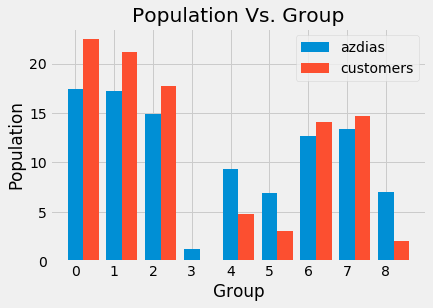

In [266]:
w = 0.4
x = list(range(9))
x2 = [i + w for i in x] 
#plt.figure(figsize=(15, 10))
plt.bar(x, azdias_groups9_percentages, w, label = "azdias")
plt.bar(x2, customer_groups9_percentages, w, label = "customers")
plt.xlabel("Group")
plt.ylabel("Population")
plt.title("Population Vs. Group")
plt.xticks(x)
plt.legend()
plt.show()


It looks like customers are nested into clusters 0, 1, and 2 to a high degree and groups 6 and 7 to a moderate degree. Clusters 3, 4, 5, and 8 are not very likely to become customers for this company so they should be eliminated from the mail order list, especially the 8'th cluster. 

Next, get the indices of the azdias dataframe that belong to a cluster. For example, to find out which customers in the azdias dataframe are in the O'th or the first cluster, the code below can provide this information:

In [282]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = principal_azdias_Df.index.values
cluster_map['cluster'] = kmeans9.labels_

In [284]:
cluster_map[cluster_map.cluster == 0][1:20]

,data_index,cluster
2,2,0
9,9,0
13,13,0
15,15,0
19,19,0
25,25,0
26,26,0
30,30,0
31,31,0
40,40,0


In [285]:
cluster_map[cluster_map.cluster == 1][1:20]

,data_index,cluster
14,14,1
16,16,1
20,20,1
33,33,1
36,36,1
37,37,1
41,41,1
49,49,1
54,54,1
58,58,1


More analysis can be done in this Unsupervised Model such as determining what columns have the most variance for a given cluster. But, at this point as long as there is enough information about new customers the model can determine what cluster they belong to and therefore whether they may be a potential customer or not. It should be stated however that the steps of PCA will need to be applied to whatever new set of data is inspected so it is congruent with the clustering model.

## EVALUATION II: Supervised Learning Model

Now that it is more clear which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, the model will be verified with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, a prediction will be created on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [133]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Now for the Supervised Learning section of the project. In this step the data 'mailout_train' will be cleaned and processed into a 'machine learning' algorithm and used to create a model that can predict if individual(s) in a general population will likely be customers or not. 

First a function that contains all of the steps to process the 'azdias' and 'customers' dataframes will be created and used to clean the 'mailout_train' dataframe in one full swoop. 

In [30]:
percent_missing(mailout_train)[1:20]

ALTER_KIND3       0.995950
ALTER_KIND2       0.982403
ALTER_KIND1       0.953727
KK_KUNDENTYP      0.589265
EXTSEL992         0.371212
HH_DELTA_FLAG     0.225269
W_KEIT_KIND_HH    0.225269
KBA05_KW2         0.201294
MOBI_REGIO        0.201294
KBA05_KW3         0.201294
KBA05_MAXAH       0.201294
KBA05_MAXBJ       0.201294
KBA05_MAXHERST    0.201294
KBA05_MOTRAD      0.201294
KBA05_MAXVORB     0.201294
KBA05_MOD1        0.201294
KBA05_MOD2        0.201294
KBA05_MOD3        0.201294
KBA05_MOD4        0.201294
dtype: float64

In [134]:
def convert_mixed(df, col_name):
    df_col = df[col_name]
    values = df_col.value_counts(ascending = False)
    df_col = pd.DataFrame(df_col)
    prior_values = values.index
    prior_values = list(prior_values)
    new_values =  list(range(len(prior_values)))
    df_col = df_col.replace(prior_values, new_values)   
    return df_col

def clean_df(df):
    

    features_list = list(feature_values['Attribute'].unique())
    feature_columns_to_drop = [col for col in features_list if col not in df.columns]
    rows_to_drop = feature_values[feature_values['Attribute'].isin(feature_columns_to_drop)]
    feature_values.drop(rows_to_drop.index, inplace = True)


    df['year'] = pd.DatetimeIndex(df['EINGEFUEGT_AM']).year
    df = df.drop(['EINGEFUEGT_AM'], axis=1)
    df = pd.DataFrame(df)

    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    df[cols] = df[cols].replace({"X": np.NaN, "XX": np.NaN})
    df[cols] = df[cols].astype(float)

    unknown_df = feature_values[feature_values['Meaning'] == 'unknown']
    unknown = pd.Series(unknown_df['Value'].values, index=unknown_df['Attribute'])
    neg_one_columns = unknown_df[unknown_df['Value']== -1].Attribute
    neg_one_columns = list(neg_one_columns)
    neg_one_and_zero_columns = ['ALTERSKATEGORIE_GROB','ANREDE_KZ','GEBAEUDETYP','HH_EINKOMMEN_SCORE','KBA05_BAUMAX','KBA05_GBZ','KKK',
            'NATIONALITAET_KZ','PRAEGENDE_JUGENDJAHRE','REGIOTYP','TITEL_KZ','WOHNDAUER_2008','W_KEIT_KIND_HH']
    neg_one_and_nine_columns = unknown_df[unknown_df['Value'] == '-1, 9'].Attribute
    neg_one_and_nine_columns = list(neg_one_and_nine_columns)
    zero_columns = unknown_df[unknown_df['Value'] == 0].Attribute
    zero_columns = list(zero_columns)

    #df[neg_one_and_zero_columns] = df[neg_one_and_zero_columns].replace({'-1, 0': np.NaN})
    df[neg_one_columns] = df[neg_one_columns].replace({'-1': np.NaN})
    df[neg_one_and_nine_columns] = df[neg_one_and_nine_columns].astype(str)
    df[neg_one_and_nine_columns] = df[neg_one_and_nine_columns].replace({'-1, 9': np.NaN})
    df[zero_columns] = df[zero_columns].replace({0: np.NaN})

    df = df.drop(['LP_STATUS_FEIN','LP_FAMILIE_FEIN','LP_LEBENSPHASE_FEIN','CAMEO_DEU_2015', 'GEBURTSJAHR', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP',  'ALTERSKATEGORIE_FEIN', 'OST_WEST_KZ'], axis = 1)
    #df['OST_WEST_KZ'] = convert_mixed(df, 'OST_WEST_KZ')
    #df = df.dropna(subset=['KBA05_GBZ'])
    df['D19_LETZTER_KAUF_BRANCHE'] = convert_mixed(df,'D19_LETZTER_KAUF_BRANCHE')
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = pd.to_numeric(df[col],errors = 'coerce')
    # Still do 'ffill' tasks. 
    for column in df.columns:
        df[column].fillna(method='ffill', inplace=True)
        df[column].fillna(method='bfill', inplace=True)
    
    return df

In [135]:
mailout_train = clean_df(mailout_train)
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
0,1763,2,1.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,...,2.0,1.0,6.0,9.0,3.0,3,0,2,4,1992.0
1,1771,1,4.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,...,2.0,1.0,4.0,9.0,7.0,1,0,2,3,1997.0
2,1776,1,1.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,...,4.0,2.0,4.0,9.0,2.0,3,0,1,4,1995.0
3,1460,2,1.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,...,11.0,11.0,6.0,9.0,1.0,3,0,2,4,1992.0
4,1783,2,1.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,...,2.0,1.0,6.0,9.0,3.0,3,0,1,3,1992.0


In [136]:
response = mailout_train['RESPONSE']
response.head()

0    0
1    0
2    0
3    0
4    0
Name: RESPONSE, dtype: int64

The variable 'response' is the dependent variable. It says whether or not the customer decided to become a customer for the mail order catalog company. 

In [137]:
x_mail = mailout_train.values
x_mail = StandardScaler().fit_transform(x_mail) # normalizing the features

In [138]:
mail_columns = mailout_train.columns

In [139]:
x_mail =  pd.DataFrame(x_mail, columns= mail_columns)

In [140]:
x_mail.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
0,-1.656309,1.031262,-0.301415,-0.377623,0.545959,-0.126954,-0.225297,-0.751880,0.468783,-0.089829,...,-0.759993,-0.833222,0.798498,0.268135,-0.522850,0.174577,-0.111975,0.824885,0.736410,-0.403378
1,-1.655987,0.323502,1.420043,0.447032,-0.373362,-0.126954,-0.225297,-0.012393,-0.364844,-0.089829,...,-0.759993,-0.833222,-0.258783,0.268135,1.425725,-1.608634,-0.111975,0.824885,-0.200391,1.185619
2,-1.655785,0.323502,-0.301415,-0.212692,-0.439028,-0.126954,-0.225297,-1.491367,-0.364844,-0.089829,...,-0.152100,-0.438862,-0.258783,0.268135,-1.009994,0.174577,-0.111975,-1.212290,0.736410,0.550020
3,-1.668538,1.031262,-0.301415,-0.707486,-0.176365,-0.126954,-0.225297,-0.012393,-0.156437,-0.089829,...,1.975524,3.110384,0.798498,0.268135,-1.497138,0.174577,-0.111975,0.824885,0.736410,-0.403378
4,-1.655502,1.031262,-0.301415,-0.212692,3.041260,-0.126954,-0.225297,-0.751880,2.622320,-0.089829,...,-0.759993,-0.833222,0.798498,0.268135,-0.522850,0.174577,-0.111975,-1.212290,-0.200391,-0.403378


In [141]:
x_mail = x_mail.drop(['RESPONSE'], axis = 1)

In this step machine learning models will evaluate the x_mail data and be scored using the function called "model_score". It uses ROC AUC to score the model. The higher ROC AUC score the better the model is at accurately predicting whether a customer falls into one of two classes, 1-They will be customer, 0-They will not be a customer. The max score is 1, a score of 0.5 means the model can only predict the class half the time and that would be a useless model. Additionally the model informs as to what hyperparameter values should be used to fine tune the model and increase performance using GridSearchCV and returning 'grid_best_score_', the hyperparameter values. 

In [142]:
def model_score(model, param_grid, X_train= x_mail, y_train=response):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - model (classifier): classification model to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - model_score: input classifier fitted to the training data
    """
    
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

When the dependent variable ("response" in this case) is a zero or one, this makes it a classification model. In essence from a purely mathematical standpoint this problem is solved through Logistic Regression. The independent variables are the values in each of the columns where one row represents one household, and the the machine learning algorithm must find what coefficients best fit the data to give the correct output for that row be it 0 or 1 where 0 means that the household/individual did not choose to become a customer and 1 means they did. There are other classification models such as Random Forest, Bagging, AdaBoost, and Gradient Boost. They all do the same thing in that they are fitting the data to the predictive outcome. Some may perform better than others, and how they work exactly will not be explored in this project. To know which will perform best try them all out and see which one(s) give the highest performance score. As stated earlier, the ROC AUC score will be the determining criteria for the models. 

In [143]:
random_forest = RandomForestClassifier(random_state= 9)
model_score(random_forest, {})

0.52964419273


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=9, verbose=0, warm_start=False)

In [153]:
log_reg = LogisticRegression(random_state=9)
log_reg = model_score(log_reg, {})

0.647361144905


In [145]:
bag_class = BaggingClassifier(random_state=12)
model_score(bag_class, {})

0.575124306044


BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=12,
         verbose=0, warm_start=False)

In [146]:
ada_boost = AdaBoostClassifier(random_state=12)
ada_boost_accuracy = model_score(ada_boost, {})


0.707222039758


This is a high score compared to the other classifiers but for some reason the 'model_score' function doesn't produce any suggested hyperparameters for the AdaBoostClassifier. 

In [147]:
# GradientBoostingClassifier
grad_boost = GradientBoostingClassifier(random_state=9)
grad_boost = model_score(grad_boost, {})
grad_boost

0.74723485405


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=9, subsample=1.0, verbose=0,
              warm_start=False)

The most successful classifiers are 'AdaBoost' and 'GradientBoost' at 76.5% and 76.7% respectively. The last step is to fine tune some of these classifiers using hyperparameters that are suggested to try to get even better results.

In [148]:
grad_boost = GradientBoostingClassifier(random_state=9)
param_grid = {'loss': ['deviance', 'exponential'],
              'max_depth': [2, 4],
              'n_estimators':[85],
              'random_state': [9]
             }
grad_boost_tuned =model_score(grad_boost, param_grid)
grad_boost_tuned

0.752325700244


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=85,
              presort='auto', random_state=9, subsample=1.0, verbose=0,
              warm_start=False)

Although there were no suggested hyperparameter values for the AdaBoostClassifier a few will be chosen anyway to see if that helps the score improve. 

In [66]:
ada_boost = AdaBoostClassifier(random_state=9)
param_grid = {
              'n_estimators':[10],
              'random_state': [9]
             }

ada_boost_tuned = model_score(ada_boost, param_grid)
ada_boost_tuned

0.774078032206


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=10, random_state=9)

And it appears that both classifiers after having been fine tuned have improved scores of 77.6% for GradientBoost and 77.4% for AdaBoost. Therefore GradientBoost will be used for the final test data set for the Kaggle competition. 

The results of the classifier scores will be shown in a bar plot below. 

<Container object of 7 artists>

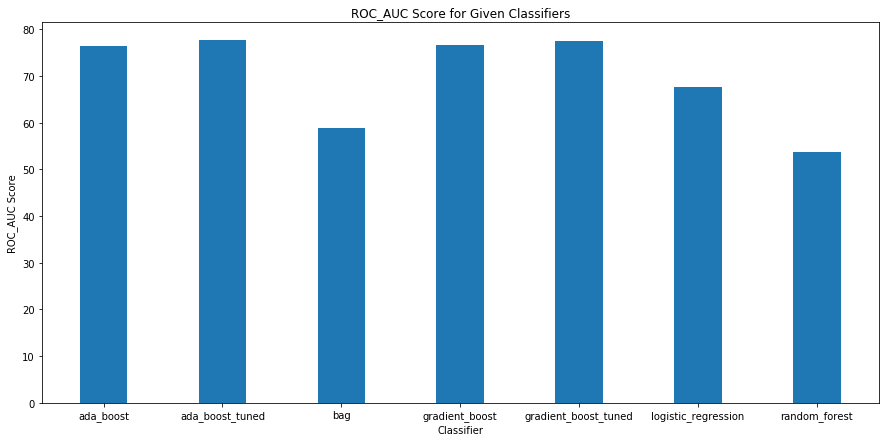

In [76]:
scores = [53.8, 67.6, 58.8, 76.5, 76.7, 77.4, 77.6]
models = [ 'random_forest', 'logistic_regression', 'bag', 'ada_boost', 'gradient_boost', 'gradient_boost_tuned',
         'ada_boost_tuned']
plt.figure(figsize=(15,7))
plt.xlabel("Classifier")
plt.ylabel("ROC_AUC Score")
plt.title("ROC_AUC Score for Given Classifiers")
plt.bar(models, scores, 0.4)

So as for the question, "Why are the results different?" Much time could be spent on this question as these classifier algorithms can be very complex but essentially it is because the algorithms are more effective on the ones that perform better. The only way to know is trial by error. The highest performing models were the ones with tuned hyperparameters (grad_boost_tuned and ada_boost_tuned) because they are optimized. 

It would also certainly be useful for the company to know what feature columns are most relevant for that the GradientBoost classifier model because that way the company would know where to move forward for data collection and customer information. They can save valuable time and resources by focusing on what is important. How to do this is shown below for the top 10 most important columns for an example.

In [56]:
# analyse the most important features of the model
top_features = pd.DataFrame({'FI':grad_boost_tuned.feature_importances_}, index = x_mail.columns)
top_features_sorted = top_features.sort_values(by=['FI'], ascending=False)
top_features_sorted.head(10)

,FI
D19_SOZIALES,0.193194
D19_KONSUMTYP_MAX,0.040368
LNR,0.036330
ANZ_TITEL,0.034907
VERDICHTUNGSRAUM,0.034614
KBA13_ANZAHL_PKW,0.032047
D19_BANKEN_LOKAL,0.028569
EINGEZOGENAM_HH_JAHR,0.027409
MIN_GEBAEUDEJAHR,0.022757
GFK_URLAUBERTYP,0.019555


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [122]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [123]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [124]:
mailout_test = clean_df(mailout_test)
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
0,1754,2,1.0,7.0,2.0,0.0,0.0,2.0,2.0,0.0,...,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4,1993.0
1,1770,-1,1.0,0.0,20.0,0.0,0.0,1.0,21.0,0.0,...,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4,1992.0
2,1465,2,9.0,16.0,2.0,0.0,0.0,4.0,2.0,0.0,...,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4,1992.0
3,1470,-1,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,6.0,6.0,3.0,2.0,9.0,2.0,3,2,4,1992.0
4,1478,1,1.0,21.0,1.0,0.0,0.0,4.0,1.0,0.0,...,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4,1992.0


In [130]:
lnr = mailout_test.LNR

In [125]:
x_mail_test = mailout_test.values
x_mail_test = StandardScaler().fit_transform(x_mail_test)

In [82]:
mail_columns = mailout_test.columns

In [126]:
x_mail_test =  pd.DataFrame(x_mail_test, columns= mail_columns)
x_mail_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
0,-1.665871,1.033789,-0.298309,-0.531881,-0.322849,-0.137287,-0.227332,-0.014568,-0.311712,-0.096117,...,0.213270,0.457982,-0.039447,0.799490,0.268221,-0.527577,0.178441,-1.213276,0.728696,-0.090509
1,-1.665225,-1.086712,-0.298309,-1.680227,0.898926,-0.137287,-0.227332,-0.753869,1.055104,-0.096117,...,0.213270,-0.762989,-0.833639,0.799490,0.268221,0.447281,0.178441,-1.213276,0.728696,-0.406333
2,-1.677546,1.033789,4.310966,0.944565,-0.322849,-0.137287,-0.227332,1.464036,-0.311712,-0.096117,...,1.475578,0.457982,-0.039447,-1.320161,0.268221,-0.040148,0.178441,0.824215,0.728696,-0.406333
3,-1.677344,-1.086712,3.158647,-1.680227,-0.390726,-0.137287,-0.227332,-1.493171,-0.383650,-0.096117,...,0.528847,0.457982,-0.039447,-1.320161,0.268221,-1.015006,0.178441,0.824215,0.728696,-0.406333
4,-1.677021,0.326956,-0.298309,1.764812,-0.390726,-0.137287,-0.227332,1.464036,-0.383650,-0.096117,...,-0.733461,-0.152504,-0.039447,-0.790249,0.268221,1.422139,1.070811,0.824215,0.728696,-0.406333


In [127]:
x_mail_test.shape

(42833, 353)

In [149]:
response = grad_boost_tuned.predict(x_mail_test)
response

array([0, 0, 0, ..., 0, 0, 0])

In [154]:
response2 = log_reg.predict(x_mail_test)

In [121]:
result.shape

(34296, 2)

In [150]:
result = pd.DataFrame({'LNR':lnr, 'RESPONSE':response})
result.to_csv(path_or_buf='./result.csv', index=False)
result.head(10)

,LNR,RESPONSE
0,1754,0
1,1770,0
2,1465,0
3,1470,0
4,1478,0
5,1782,0
6,1485,0
7,1519,0
8,1835,0
9,1522,0


In [155]:
result2 = pd.DataFrame({'LNR':lnr, 'RESPONSE':response2})
result2.to_csv(path_or_buf='./result.csv', index=False)
result2.head(10)

,LNR,RESPONSE
0,1754,0
1,1770,0
2,1465,0
3,1470,0
4,1478,0
5,1782,0
6,1485,0
7,1519,0
8,1835,0
9,1522,0


In [156]:
result2[result2["RESPONSE"]>0]

,LNR,RESPONSE


In [157]:
result[result["RESPONSE"]>0]

,LNR,RESPONSE
13408,84655,1
21785,48865,1


Selecting subsets of a DataFrame https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/03_subset_data.html

PCA article:
https://towardsdatascience.com/dimension-reduction-techniques-with-python-f36ca7009e5c

optimizing hyperparameters: https://medium.com/analytics-vidhya/optimize-hyperparameters-with-gridsearch-d351b0fd339d